# Homeworks - Big Data and Public Policy Class

*Name*: Andreas Eckmann

*E-Mail*: eckmanna@ethz.ch

In [4]:
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None # Display all columns of a dataframe
pd.options.display.max_rows = 700
from pprint import pprint

import tweepy
from tweepy import OAuthHandler
import time
import datetime
import os
import numpy as np
import pandas as pd
import yfinance as yf
import re
from bs4 import BeautifulSoup
import sklearn

In [5]:
# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

In [149]:
# for regression models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

**Step 1a: `X` variables** [week 2]
- Fetch the data using the **twitter API** or any other API or website that you are interested in.
- Beware of the rate limits and organize your program so as to overcome them if needed
- The data should include some text, but might also have other interesting variables (retweets, favorites...)
- Create some (non-text based) `X_num` variables that you will use for the prediction

In [6]:
#this you get when you make create an application on twitter as a dev
consumer_key="7X8q1LteL1qOLRg4DSoiI0lyk"
consumer_secret="Bb08vV5XoxDEP4SGLJfkvEpuwvxEDvzVSRGTptzQCjC9XVmquP"
access_token="1230145588659998721-EQb8DoMYnorBtqAuEPMZtZcXumzuAe"
access_token_secret="mzurpOu1LWhj0NU9pctgYZ6OBzhQvyqw8hvRNpe3yI4Qc"

## Accessing the Twitter API using `tweepy`

Twitter requires all requests to use `OAuth` for authentication

In [7]:
# Authenticate to Twitter
auth = OAuthHandler(consumer_key, consumer_secret) #creating an OAuthHandler instance
auth.set_access_token(access_token, access_token_secret)

# We specify wait_on_rate_limit_notify==True & wait_on_rate_limit=True. The API method will wait once you’ve reached your rate limit and prints out a message
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [8]:
# test authentication
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")


Authentication OK


In [9]:
# most recent tweets about Beyond Meat
tweets = api.search(q="Beyond Meat", lang="en") # TODO: How is it set to recent tweets?
for tweet in tweets:
    print(tweet.text) # printing the first tweet

According to their last quarterly report, Beyond Meat's gross profit margin in the first quarter was as high as 38.… https://t.co/f0oer6nwCp
RT @TheInvestorGuy_: $BYND - Beyond Meat: Earning A Meaty Profit. https://t.co/BIlVN31XwT
All plant based meat barbecue, am getting better at this stuff, don't feel any difference any more, Burgers are Bey… https://t.co/iRKR3TF540
RT @MadMoneyOnCNBC: "Here’s the thing: there are good reasons for Beyond Meat’s incredible outperformance, but they’re not the kind of reas…
RT @IDAUSA: We love this! 😍
Joaquin and Rooney are donating more than one million #Vegan meals to food insecure Americans and emergency ser…
@albertogarciafx Beyond meat
RT @westberksbrew: Launching soon, our @vicarsgame collaboration BBQ Boxes! The best quality British beer, meat &amp; game to Berkshire &amp; beyon…
RT @westberksbrew: Launching soon, our @vicarsgame collaboration BBQ Boxes! The best quality British beer, meat &amp; game to Berkshire &amp; beyon…
Joe rogan said beyo

In [10]:
target='BeyondMeat' #'BeyondMeat'
user = api.get_user(target) # argument = id, user_id, screen_name
pprint(user._json)

{'contributors_enabled': False,
 'created_at': 'Thu May 03 05:40:43 +0000 2012',
 'default_profile': False,
 'default_profile_image': False,
 'description': "Meat that's made from plants, made for meat lovers. \n"
                '#GoBeyond',
 'entities': {'description': {'urls': []},
              'url': {'urls': [{'display_url': 'beyondmeat.com',
                                'expanded_url': 'http://www.beyondmeat.com',
                                'indices': [0, 22],
                                'url': 'http://t.co/4ZbzGc2iMf'}]}},
 'favourites_count': 18403,
 'follow_request_sent': False,
 'followers_count': 110539,
 'following': True,
 'friends_count': 693,
 'geo_enabled': True,
 'has_extended_profile': False,
 'id': 569714177,
 'id_str': '569714177',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': None,
 'listed_count': 1089,
 'location': 'El Segundo, CA',
 'name': 'Beyond Meat',
 'notifications': False,
 'profile_background_color': 'FAF5E2',
 'profile

In [11]:
# Some attributes of the `user` object:
print("Name:", user.name)
print("Screen name:", user.screen_name)
print("Number of followers:" ,  user.followers_count)
pprint("description: " + user.description)
pprint("Number of tweets published: " + str(user.statuses_count))
pprint("friends_count: " + str(user.friends_count))

Name: Beyond Meat
Screen name: BeyondMeat
Number of followers: 110539
"description: Meat that's made from plants, made for meat lovers. \n#GoBeyond"
'Number of tweets published: 24066'
'friends_count: 693'


In [12]:
# Note: This code (cell) was written with the help of Gian-Luca and Felix 
def fetch_tweets(account, n_tweets):
    """Fetch data from Beyond Meat twitter account"""
    df_out = pd.DataFrame()
    
    try:   
        # Put the tweets into a data frame object
        tweet_count = 0
        for tweet in tweepy.Cursor(api.user_timeline, 
                                   screen_name=target, 
                                   tweet_mode ='extended',
                                   include_rts = False).items(n_tweets):
    
                    # Transform the json into a dataframe
                    df_tweet = pd.DataFrame.from_dict(tweet._json, orient='index', 
                                                      columns=[tweet_count]) # , sleep_on_rate_limit=True
      
                    # Concatenate the tweet dataframe to the df_tweets dataframe
                    df_out = pd.concat([df_tweet, df_out], axis=1)
    
                    # count the number of tweets fetched
                    tweet_count += 1 
    
        time.sleep(1)
    
    # except if TweepError arises
    except tweepy.TweepError: #the error arises when the user has protected tweets
        print("Failed to run the command "
              "on user {}, Skipping...".format(account))
    
    # except if RateLimitError arises
    except tweepy.RateLimitError:
        print("resource usage limit: {} skipped".format(account))
        time.sleep(15 * 60) # wait 15 mins
        
    return df_out

In [13]:
# IMPORTANT NOTE: This part of the code is commented out, so that the data obtained from twitter remains the same and does not change with the date (2020-05-02)
# Calling the function (uncomment to run)

#df_tweets = fetch_tweets(target,2000)
#print(df_tweets.columns)

In [14]:
"""
# Transpose the data set
df_tweets=df_tweets.transpose() # Transpose the dataset
print(df_tweets.columns)
print(df_tweets.shape)
df_tweets.head()
"""

'\n# Transpose the data set\ndf_tweets=df_tweets.transpose() # Transpose the dataset\nprint(df_tweets.columns)\nprint(df_tweets.shape)\ndf_tweets.head()\n'

In [15]:
# Reduce data set and save the data in a csv file (uncomment to run)

#df_tweets_small=df_tweets[['full_text', 'created_at', 'retweet_count', 'favorite_count']] # 'user'
#df_tweets_small.head()

In [16]:
parent_path=os.path.dirname(os.getcwd()) # os.getcwd() fetchs the current path, 
data_path=os.path.join(parent_path, 'data')
print(data_path)

C:\Users\Andi Eckmann\Desktop\ETH Studium\MASTERSTUDIUM\2. Semester\Big Data for Public Policy\big_data_policy_2020\data


In [17]:
# Saving fetched tweets as CSV file (uncomment to run)
#df_tweets_small.to_csv(data_path+'/Beyond_Meat_tweets_{}.csv'.format(np.datetime64('today','D')), sep= ';')
#print("{} tweets fetched.\n".format(df_tweets.shape[0]))

In [18]:
# Load the data from csv file (date 2020-05-02)
df_raw = pd.read_csv(data_path+'/Beyond_Meat_tweets_{}.csv'.format(np.datetime64('2020-05-02')), sep=';')
print(df_raw.shape,
      df_raw.head())

(2000, 5)    Unnamed: 0                                          full_text  \
0        1999  @AaronMinogueUSA @Vegicano @FollowYourHeart A+...   
1        1998  @BellaMarieCt1 Check out our store-locator to ...   
2        1997  @BoomChickaWow1 Thank you for you patience and...   
3        1996  @Captain_Quench @AWCanada We are working on ex...   
4        1995  @paulasulllivan @WholeFoods Hey Paula! We are ...   

                       created_at  retweet_count  favorite_count  
0  Fri Aug 17 00:40:22 +0000 2018              0               1  
1  Fri Aug 17 00:45:06 +0000 2018              0               1  
2  Fri Aug 17 00:45:57 +0000 2018              0               1  
3  Fri Aug 17 00:46:36 +0000 2018              0               1  
4  Fri Aug 17 00:48:11 +0000 2018              1               2  


In [19]:
# Note: This code (cell) was written with the help of Gian-Luca 
# obtain tweets as list
all_texts = list(df_raw['full_text'])

# search for hashtags and remove special characters
# and separate each word in the tweets --> important for keyword search afterwards
ats = []
hashtags = []
texts = []
for i in all_texts:
    a = []
    tex = []
    hashs = []
    for word in i.split():
        hashtag = re.search(r'(?<=#)\w+', word)
        at = re.search(r'(?<=@)\w+', word)
        if hashtag != None:
            hashs.append(hashtag.group().lower())
        if at != None:
            a.append(at.group().lower())
        else:
            text = re.search(r'\w+', word)
            if text != None:
                tex.append(text.group().lower())
    ats.append(a)
    texts.append(tex)
    hashtags.append(hashs)

In [20]:
#create data frame for overview:
dict1 = {'all_texts':all_texts, 'ats':ats, 'texts':texts, 'hashtags':hashtags}
df_ov =pd.DataFrame(dict1)
df_ov.head()

,all_texts,ats,texts,hashtags
0,@AaronMinogueUSA @Vegicano @FollowYourHeart A+...,"[aaronminogueusa, vegicano, followyourheart]","[a, with, the, gif, choice]",[]
1,@BellaMarieCt1 Check out our store-locator to ...,[bellamariect1],"[check, out, our, store, to, find, a, store, n...",[]
2,@BoomChickaWow1 Thank you for you patience and...,[boomchickawow1],"[thank, you, for, you, patience, and, support,...",[]
3,@Captain_Quench @AWCanada We are working on ex...,"[captain_quench, awcanada]","[we, are, working, on, expanding, internationa...",[]
4,@paulasulllivan @WholeFoods Hey Paula! We are ...,"[paulasulllivan, wholefoods]","[hey, paula, we, are, currently, experiencing,...",[]


In [21]:
# Save as CSV file (uncomment to run code)
# df_ov.to_csv(data_path+'/Beyond_Meat_tweets_overview_{}.csv'.format(np.datetime64('today','D')), sep= ';')

In [22]:
# define list of search strings:
hashtag_search_strings = ['stock','BYND','Nasdaq', 'vegan', 'beyondburger','GoBeyond', 'plantbased', 'plantbasedparty', 'eathealthy', 'WorldHealthDay',
                          'TheGreatAmericanTakeout', 'BeyondBeef', 'GoBeyondBreakfast', 'BeyondAmbassador', 'WorldKindnessDay']
text_search_strings = ['stock exchange', 'carbon', 'environment', 'meat', 'animals', 'climate', 'green', 'planet', 'health', 'healthy', 'food',
                       'stock','BYND','Nasdaq', 'vegan', 'beyondburger','GoBeyond', 'plantbased', 'plantbasedparty', 'eathealthy', 'WorldHealthDay',
                          'TheGreatAmericanTakeout', 'BeyondBeef', 'GoBeyondBreakfast', 'BeyondAmbassador', 'WorldKindnessDay']

In [23]:
#loop over hashtags and texts
hash_occ = []
for i in hashtags:
    hashs = []
    for j in i:
        if j in hashtag_search_strings:
            hashs.append(j)
    hash_occ.append(hashs)
        
text_occ = []
for i in texts:
    tex = []
    for j in i:
        if j in text_search_strings:
            tex.append(j)
    text_occ.append(tex)

In [24]:
#count keyword and key hastags per tweet 
key_count = []
for i in text_occ:
    if i != None:
        key_count.append(len(i))
    else:
        key_count.append(0)
        
key_hash_count = []
for i in hash_occ:
    if i != None:
        key_hash_count.append(len(i))
    else:
        key_hash_count.append(0)


In [25]:
#get columns on time, retweets, and favourite counts from df_raw file as lists
created_at = df_raw['created_at']
retweet_count = df_raw['retweet_count']
favorite_count = df_raw['favorite_count']

# deal with date format issue and change format to yfinance default setting:
change_date = []
for i in created_at:
    convert_date = datetime.datetime.strptime(i, '%a %b %d %H:%M:%S +0000 %Y')
    change_date.append(convert_date.strftime('%Y-%m-%d'))


#create dict with all the relevant informations:
dict2 = {'tweet':all_texts, 'created at':change_date, 'favorite count':favorite_count, 'retweet count':retweet_count,
         'key hashtag count':key_hash_count,'key hashtag':hash_occ, 'keyword count':key_count ,'keywords':text_occ }

# Create data frame of all the numeric values needed for the stock predictions:
X_num_raw = pd.DataFrame(dict2)
X_num_raw.head()

,tweet,created at,favorite count,retweet count,key hashtag count,key hashtag,keyword count,keywords
0,@AaronMinogueUSA @Vegicano @FollowYourHeart A+...,2018-08-17,1,0,0,[],0,[]
1,@BellaMarieCt1 Check out our store-locator to ...,2018-08-17,1,0,0,[],0,[]
2,@BoomChickaWow1 Thank you for you patience and...,2018-08-17,1,0,0,[],0,[]
3,@Captain_Quench @AWCanada We are working on ex...,2018-08-17,1,0,0,[],0,[]
4,@paulasulllivan @WholeFoods Hey Paula! We are ...,2018-08-17,2,1,0,[],0,[]


In [26]:
# remove all the brackets in the data frame X_num
X_num_raw['keywords'] = X_num_raw['keywords'].str[0]
X_num_raw['key hashtag'] = X_num_raw['key hashtag'].str[0]
X_num_raw

,tweet,created at,favorite count,retweet count,key hashtag count,key hashtag,keyword count,keywords
0,@AaronMinogueUSA @Vegicano @FollowYourHeart A+...,2018-08-17,1,0,0,NaN,0,NaN
1,@BellaMarieCt1 Check out our store-locator to ...,2018-08-17,1,0,0,NaN,0,NaN
2,@BoomChickaWow1 Thank you for you patience and...,2018-08-17,1,0,0,NaN,0,NaN
3,@Captain_Quench @AWCanada We are working on ex...,2018-08-17,1,0,0,NaN,0,NaN
4,@paulasulllivan @WholeFoods Hey Paula! We are ...,2018-08-17,2,1,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...
1995,@jeramiedreyfuss @catnamedcatteri @WSJ Thank y...,2020-05-01,1,0,0,NaN,0,NaN
1996,@ShaniasmithCo @xmxcc 😋,2020-05-01,1,0,0,NaN,0,NaN
1997,@thefawz Looks delicious 😋,2020-05-01,3,0,0,NaN,0,NaN
1998,@jamietworkowski @ImpossibleFoods 🌱💚🌎,2020-05-01,3,0,0,NaN,0,NaN


**Now:** Lets have a look at what the most popular keywords and hashtags are:

In [27]:
# most popular keyword
keyword_counts = X_num_raw['keywords'].value_counts().rename_axis('unique_values').reset_index(name='counts')
keyword_counts

,unique_values,counts
0,meat,180
1,beyondburger,143
2,food,23
3,vegan,16
4,stock,13
5,plantbased,6
6,climate,5
7,health,4
8,plantbasedparty,3
9,environment,2


In [28]:
# most popular key hashtags
key_hashtag_counts = X_num_raw['key hashtag'].value_counts().rename_axis('unique_values').reset_index(name='counts')
key_hashtag_counts

,unique_values,counts
0,beyondburger,153
1,plantbased,6
2,plantbasedparty,3


In [29]:
# Now look for the numerical variables of the tweets that were tweeted
# within a day and sum them up to one value per day:
    
addition = []
set_created = set(change_date)
for k in set_created: 
    index_doppelt = [] 
    for ind,i in enumerate(change_date):
        if i == k: # put toghether all tweets per day
            index_doppelt.append(ind)
    # sum up all counts and keywords, and so on into one date        
    addition.append([k,sum(X_num_raw.iloc[index_doppelt]['retweet count']),
                     sum(X_num_raw.iloc[index_doppelt]['favorite count']),
                     sum(X_num_raw.iloc[index_doppelt]['key hashtag count']),
                     sum(X_num_raw.iloc[index_doppelt]['keyword count'])])


In [30]:
# create Data Frame X_num, wich contains all necessary numeric Variables
X_num = pd.DataFrame(addition)
X_num.head()

,0,1,2,3,4
0,2020-01-08,57,599,0,1
1,2018-09-24,103,389,2,5
2,2018-09-17,0,0,0,0
3,2019-04-01,2,76,0,0
4,2020-04-22,55,202,0,0


In [31]:
# Name Columns
X_num.columns = ['Date','retweet count', 'favorite count','key hashtag count', 'keyword count']
X_num.head()

,Date,retweet count,favorite count,key hashtag count,keyword count
0,2020-01-08,57,599,0,1
1,2018-09-24,103,389,2,5
2,2018-09-17,0,0,0,0
3,2019-04-01,2,76,0,0
4,2020-04-22,55,202,0,0


In [32]:
# Sort now by Date
X_num['Date'] =pd.to_datetime(X_num.Date)
X_num = X_num.sort_values('Date')
# Reset Index
X_num = X_num.reset_index(drop=True)
X_num.head()

,Date,retweet count,favorite count,key hashtag count,keyword count
0,2018-08-17,34,189,0,1
1,2018-08-18,69,290,0,0
2,2018-08-19,15,62,0,0
3,2018-08-20,56,230,2,2
4,2018-08-21,6,41,1,2


**Step 1b: continuous `y` variables** [week 2]
- Fetching the data: 
    - if you work on the suggested idea, you can easily access daily stock prices using the [`yfinance` package](https://pypi.org/project/yfinance/)  (see below)
    - otherwise, you can find some interesting data listed in the syllabus

In [33]:
bynd = yf.Ticker("BYND")
# get stock info
bynd.info

{'zip': '90245',
 'sector': 'Consumer Defensive',
 'fullTimeEmployees': 472,
 'longBusinessSummary': 'Beyond Meat, Inc., a food company, engages in the provision of revolutionary plant-based meats in the United States and internationally. It offers its products in plant-based platforms of beef, pork, and poultry in ready-to-cook and ready-to-heat formats. The company sells its products through grocery, mass merchandiser, club and convenience store, and natural retailer channels, as well as direct to consumer and various food-away-from-home channels under the Beyond Meat, Beyond Burger, Beyond Beef, Beyond Sausage, Beyond Breakfast Sausage, Beyond Chicken, Beyond Fried Chicken, Beyond Meatball, the Caped Steer Logo, GO BEYOND, Eat What You Love, The Cookout Classic, The Future of Protein, and The Future of Protein Beyond Meat brand names. The company was formerly known as Savage River, Inc. and changed its name to Beyond Meat, Inc. in September 2018. Beyond Meat, Inc. was founded in 200

In [34]:
# get historical market data
hist = bynd.history(period="max")
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-05-02,46.00,72.95,45.00,65.75,23119000,0,0
2019-05-03,72.00,74.00,65.66,66.79,13139400,0,0
2019-05-06,62.73,74.84,62.50,74.79,8746200,0,0
2019-05-07,77.14,85.45,75.00,79.17,16532100,0,0
2019-05-08,83.61,85.38,70.79,72.25,14696300,0,0


In [35]:
# fetch stock prices from Beyond Meat
# Take same dates as for the tweets (stock data starts at 2019-05-02)
bynd_stock_df = yf.download('BYND',
                      start='2018-08-17', 
                      end='2020-05-02',
                      interval= '1d',
                      progress=False)

In [36]:
# show actions (dividends, splits)
bynd.actions

,Dividends,Stock Splits
Date,,


In [37]:
# show earnings
bynd.earnings
bynd.quarterly_earnings

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [70]:
bynd_stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-02,46.000000,72.949997,45.000000,65.750000,65.750000,23119000
2019-05-03,72.000000,74.000000,65.660004,66.790001,66.790001,13139400
2019-05-06,62.730000,74.839996,62.500000,74.790001,74.790001,8746200
2019-05-07,77.139999,85.449997,75.000000,79.169998,79.169998,16532100
2019-05-08,83.610001,85.379997,70.785004,72.250000,72.250000,14696300


**Step 1c: merge `X_num` and `y`** [week 2]
- Beware of the temporality: in the case of the proposed study on stock market prices, you will have to deal with the fact that the X is at the tweet level while `y` is daily. 


In [71]:
# merge 
# use option, how = 'inner' to deal with temporality issue 
y = bynd_stock_df['High']
df1 = pd.merge(X_num, y, how='inner', on=['Date'])
df1.head()

,Date,retweet count,favorite count,key hashtag count,keyword count,High
0,2019-05-02,908,3261,0,2,72.949997
1,2019-05-03,144,379,1,2,74.000000
2,2019-05-06,117,606,1,1,74.839996
3,2019-05-07,3,66,0,0,85.449997
4,2019-05-08,26,159,0,0,85.379997


In [72]:
# save it as csv file (uncomment to run code)
# df1.to_csv(data_path +'/X_num_y_merged.csv')

In [347]:
# load data from csv file X_num_y_merged
df1 = pd.read_csv(data_path +'/X_num_y_merged.csv').iloc[:, 1:] #avoiding "unnamed"-row

print(df1.shape,
      df1.head())

(226, 6)          Date  retweet count  favorite count  key hashtag count  \
0  2019-05-02            908            3261                  0   
1  2019-05-03            144             379                  1   
2  2019-05-06            117             606                  1   
3  2019-05-07              3              66                  0   
4  2019-05-08             26             159                  0   

   keyword count       High  
0              2  72.949997  
1              2  74.000000  
2              1  74.839996  
3              0  85.449997  
4              0  85.379997  


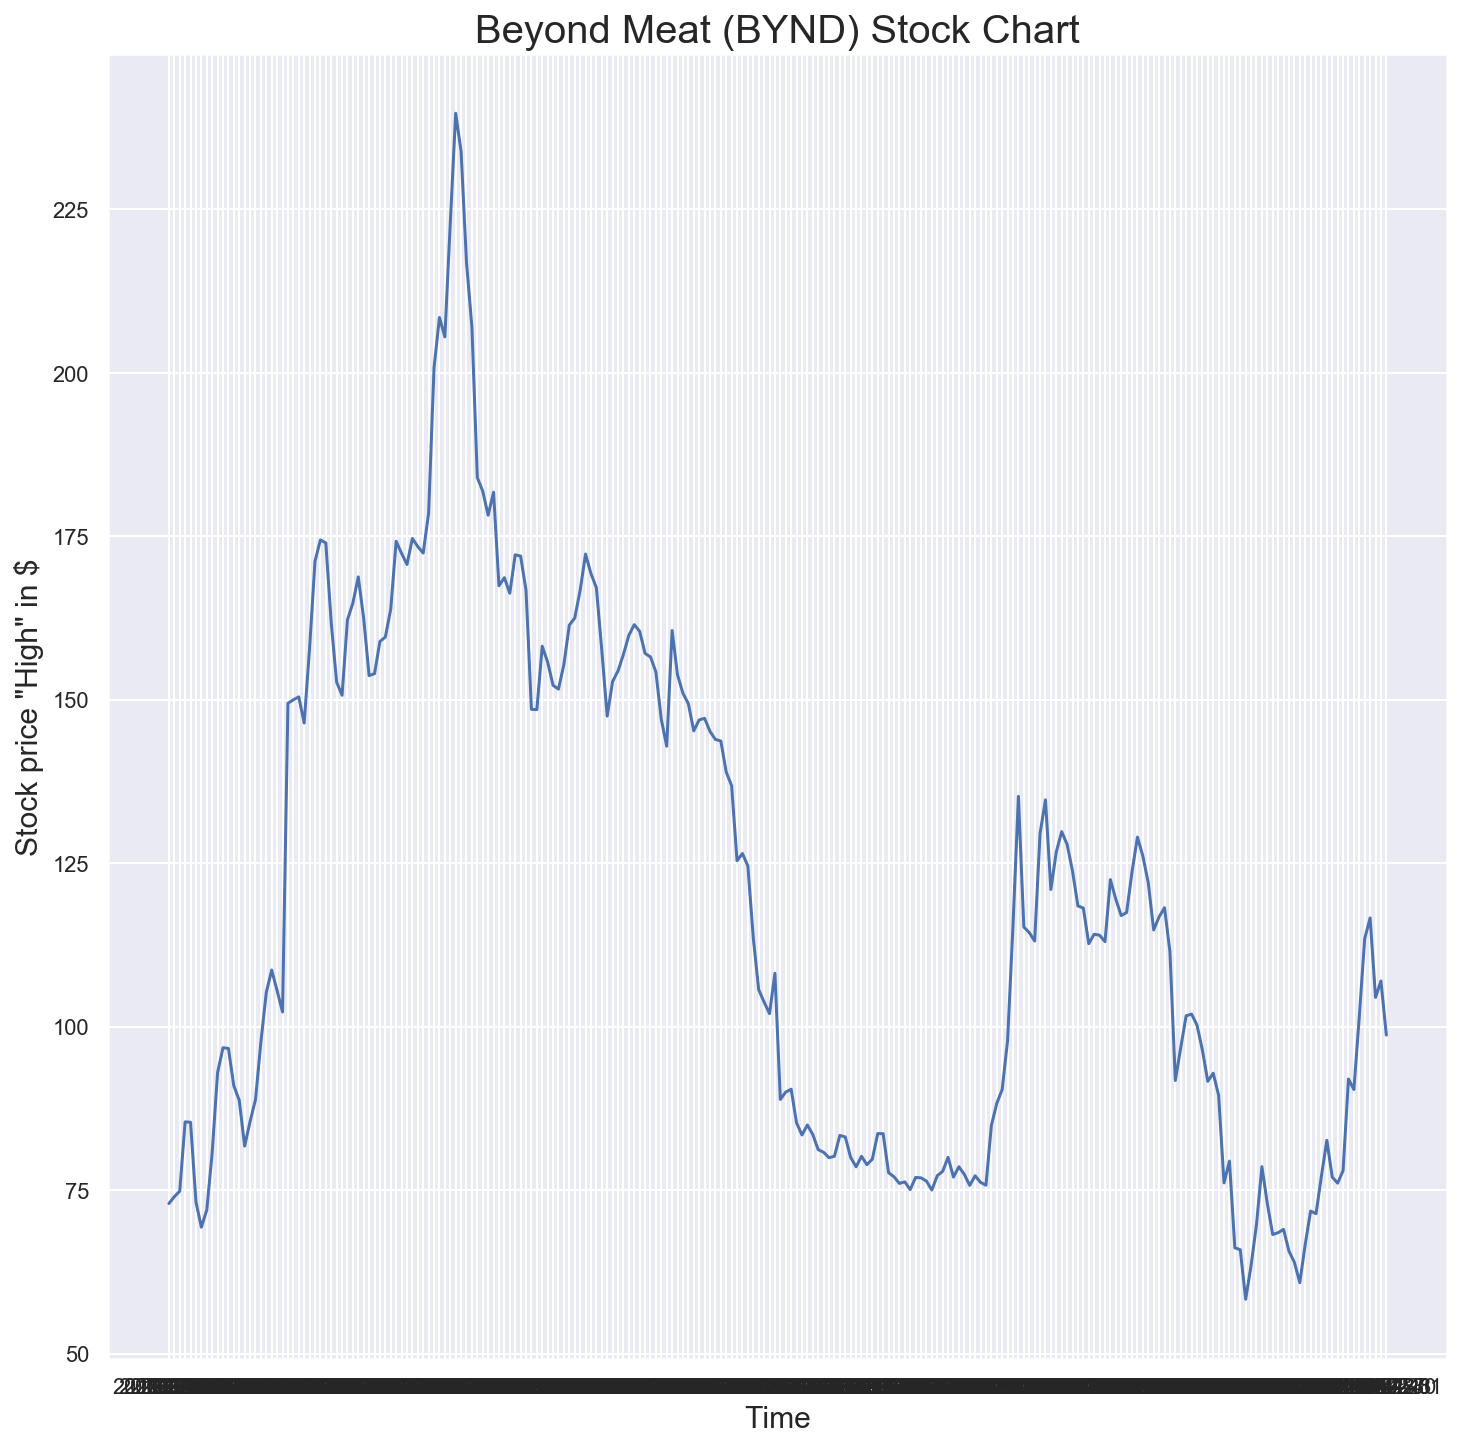

In [348]:
# Plotting stock data
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

y = df1['High']
x = df1['Date']

#df = df1.as_matrix(columns=df1.columns[1:7])

fig, ax = plt.subplots()
ax.plot('Date', 'High', data=df1)

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel("Time", size=15)
plt.ylabel('Stock price "High" in $', size=15)
plt.title('Beyond Meat (BYND) Stock Chart', size=20)

plt.show()

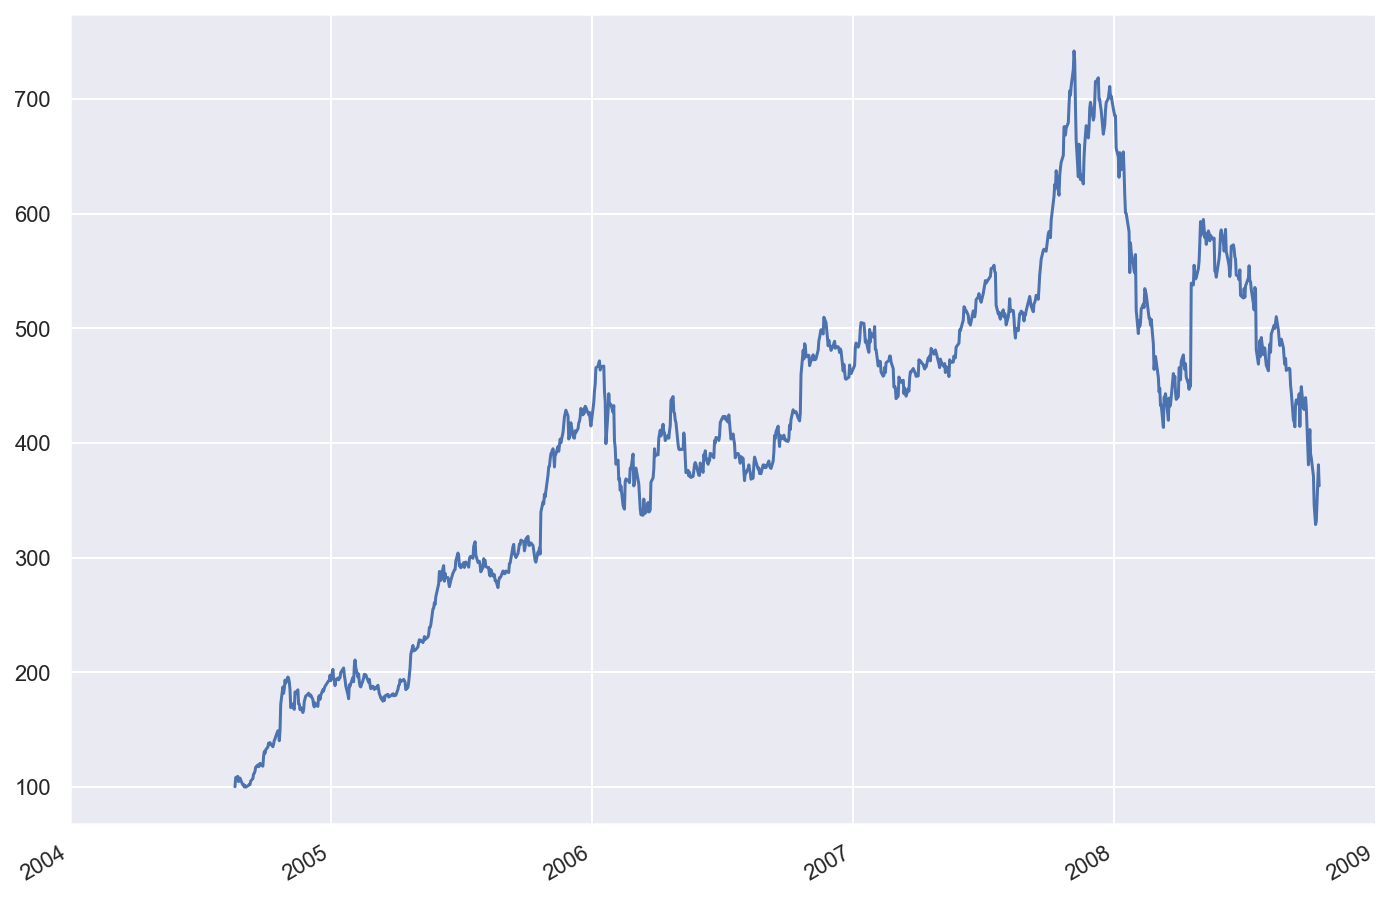

In [349]:
# Example found online -> that's how it should look like!
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# Load a numpy structured array from yahoo csv data with fields date, open,
# close, volume, adj_close from the mpl-data/example directory.  This array
# stores the date as an np.datetime64 with a day unit ('D') in the 'date'
# column.
with cbook.get_sample_data('goog.npz') as datafile:
    data = np.load(datafile)['price_data']

fig, ax = plt.subplots()
ax.plot('date', 'adj_close', data=data)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(data['date'][0], 'Y')
datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

In [350]:
# Sort now by Date
df1['Date'] =pd.to_datetime(df1.Date)
df1 = df1.sort_values('Date')

# Reset Index
#df1 = df1.reset_index(drop=True)

df1.head()

,Date,retweet count,favorite count,key hashtag count,keyword count,High
0,2019-05-02,908,3261,0,2,72.949997
1,2019-05-03,144,379,1,2,74.000000
2,2019-05-06,117,606,1,1,74.839996
3,2019-05-07,3,66,0,0,85.449997
4,2019-05-08,26,159,0,0,85.379997


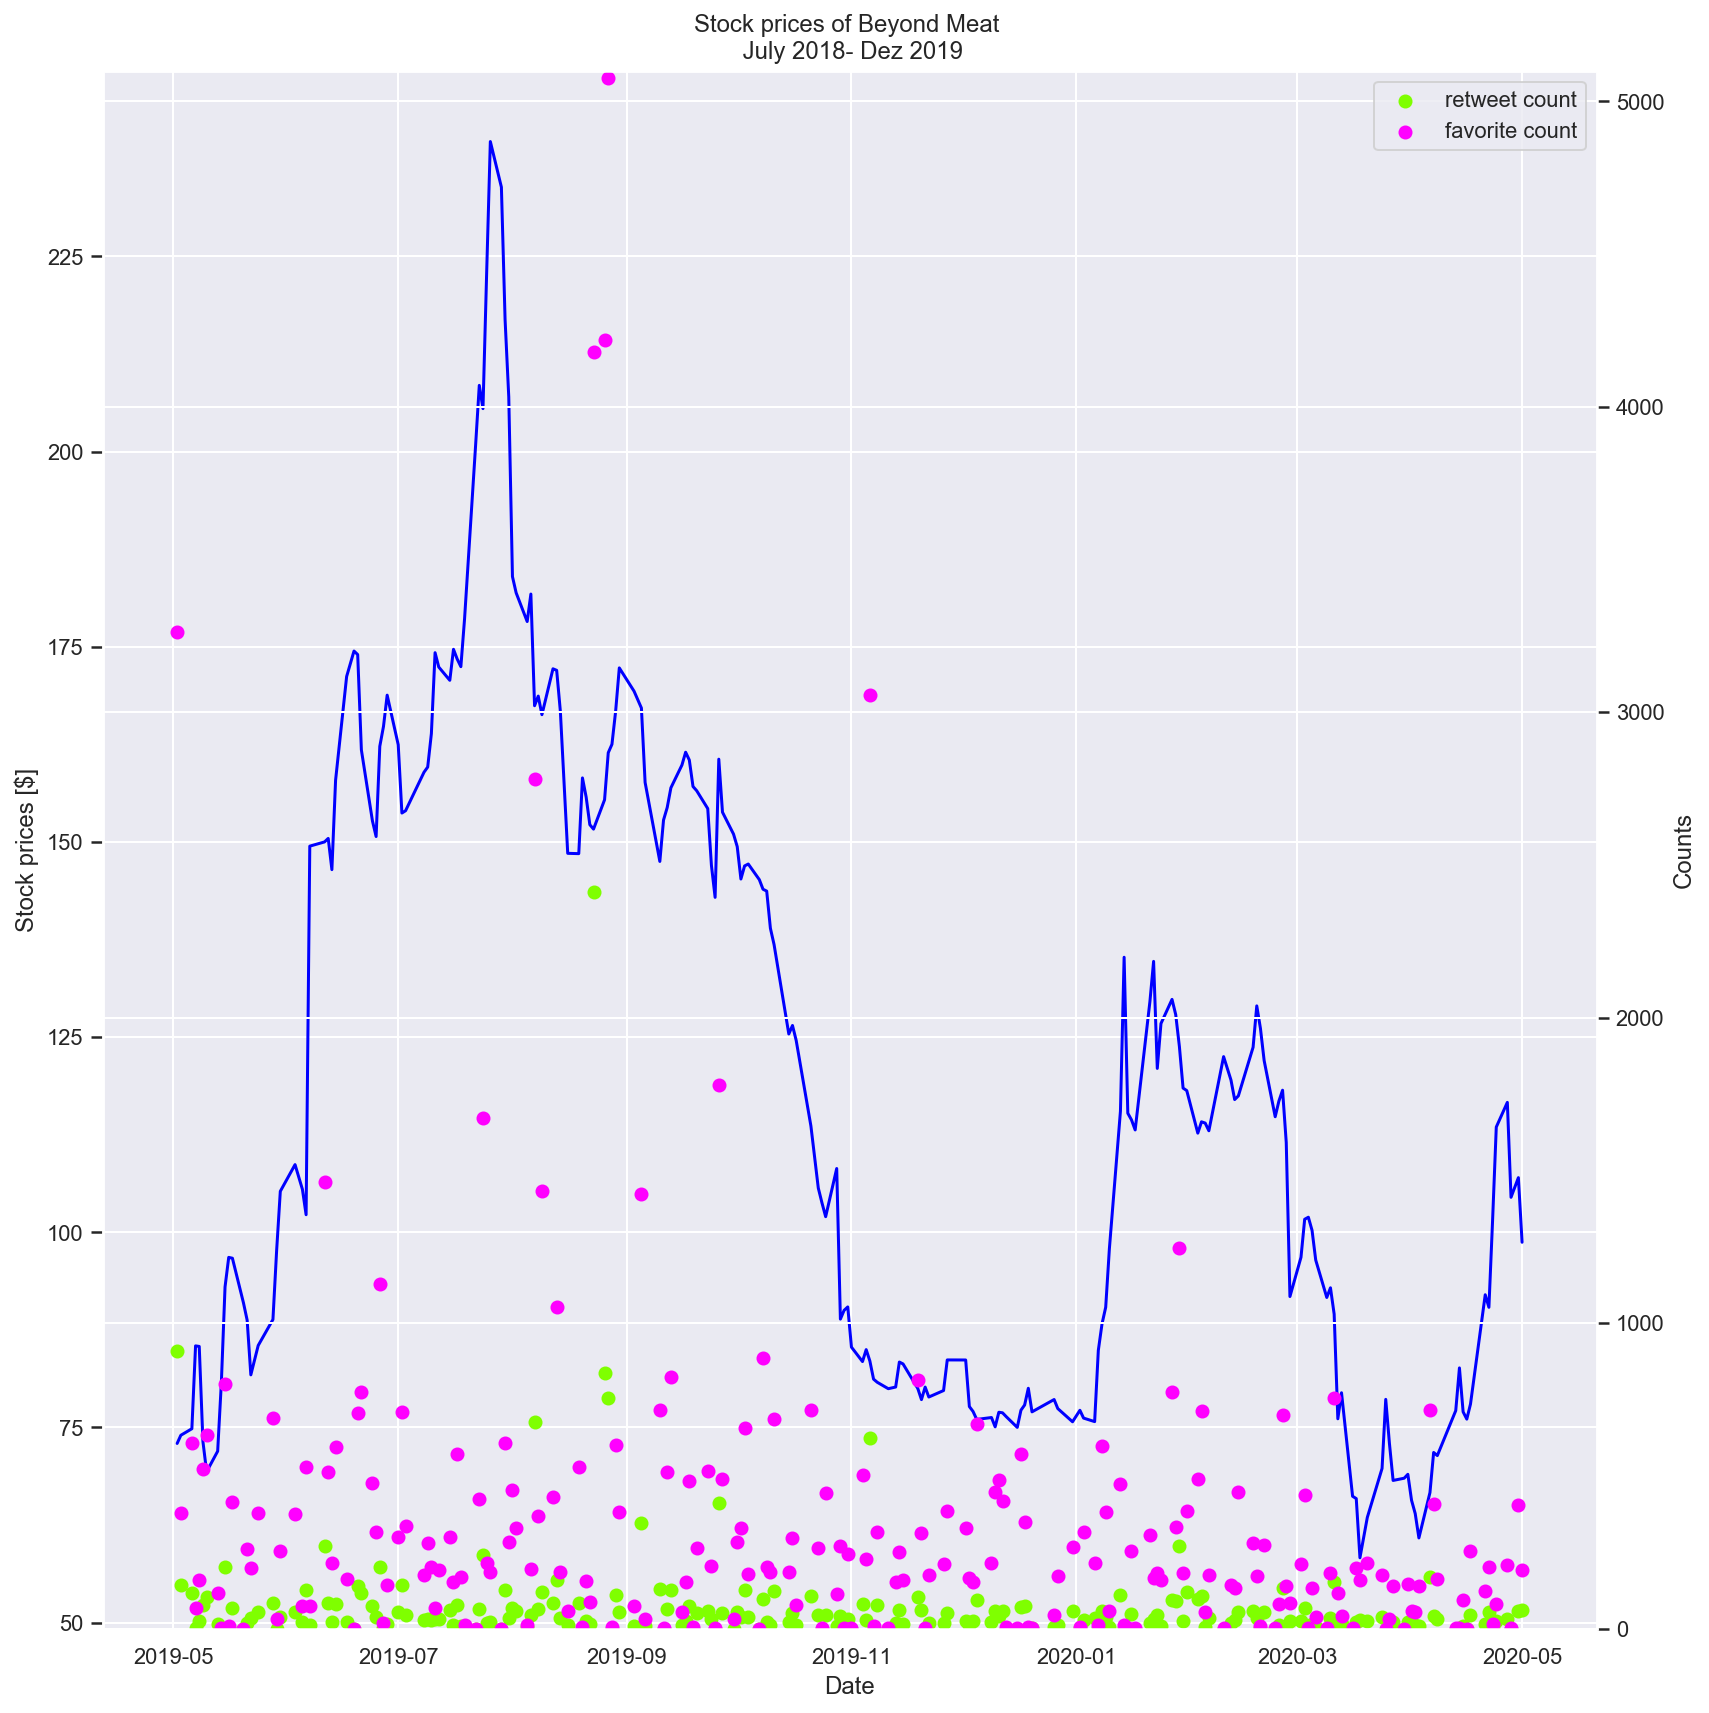

In [351]:
# plot X_num over time period of interest

fig, ax1 = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis for ax1
ax1.plot("Date", "High", data = df1, color= "blue")


# Set title and labels for axes
ax1.set(xlabel="Date",
       ylabel="Stock prices [$]",
       title="Stock prices of Beyond Meat \n July 2018- Dez 2019")

# Define the date format
date_form = DateFormatter("%Y-%m")
ax1.xaxis.set_major_formatter(date_form)

# Ensure a major tick for eg. each month using (interval=1) 
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

#add x-axise for ax2
ax2.set(ylabel = "Counts", ylim =(0, 5100))
ax2.scatter("Date", "retweet count", data = df1, color = "chartreuse")
ax2.scatter("Date", "favorite count", data = df1, color = "fuchsia")
ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

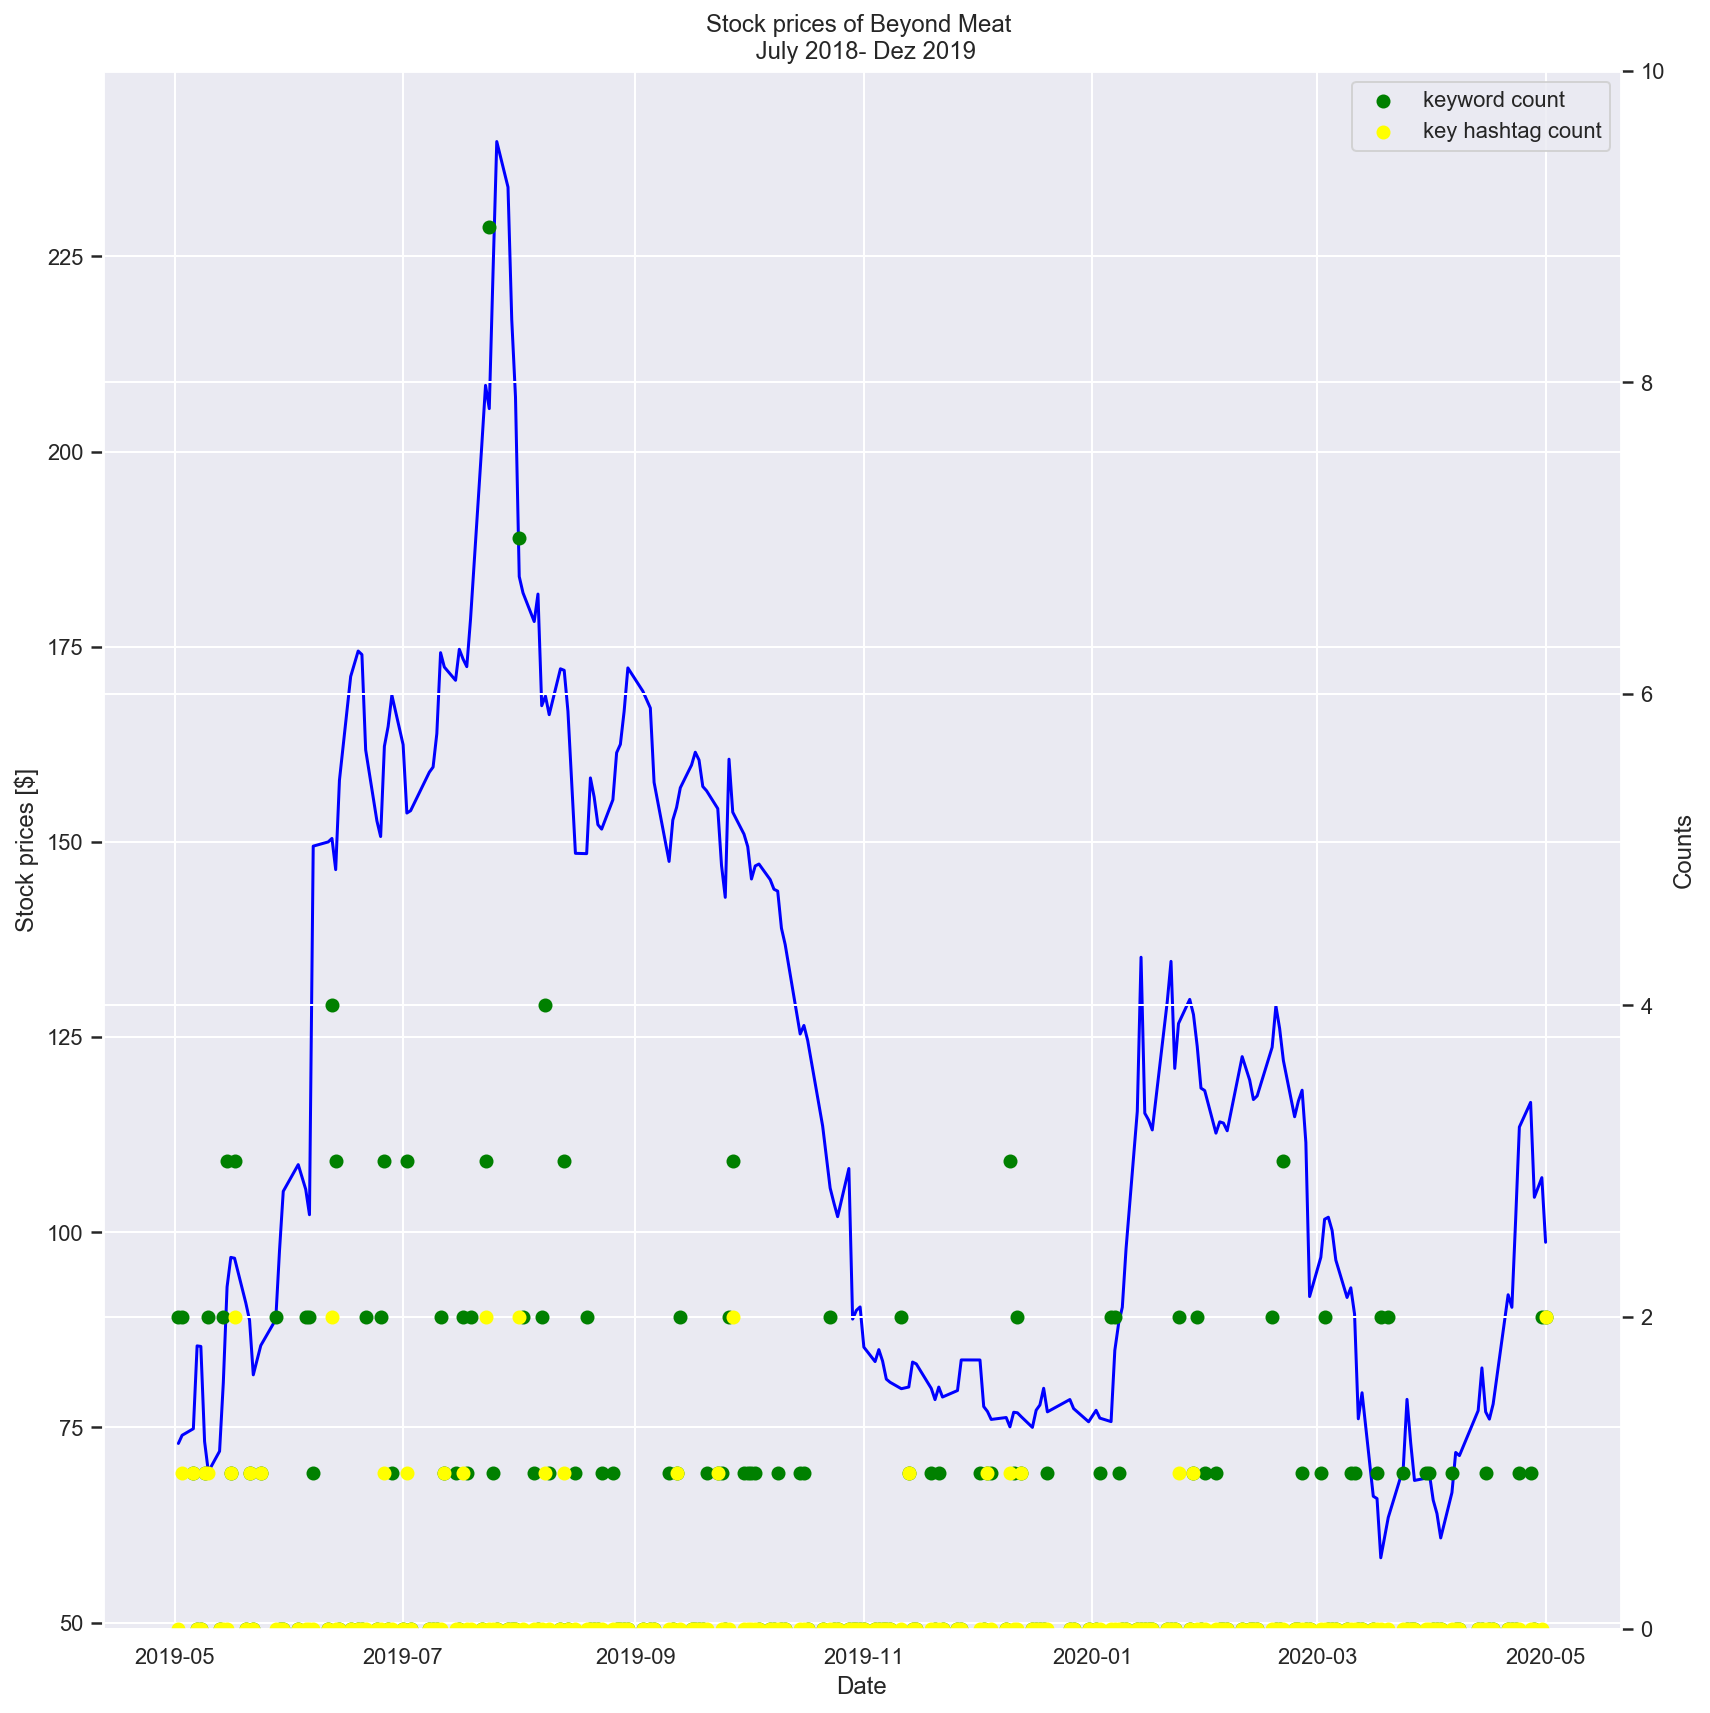

In [352]:
# plot X_num over time period of interest

fig, ax1 = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis for ax1
ax1.plot("Date", "High", data = df1, color= "blue")


# Set title and labels for axes
ax1.set(xlabel="Date",
       ylabel="Stock prices [$]",
       title="Stock prices of Beyond Meat \n July 2018- Dez 2019")

# Define the date format
date_form = DateFormatter("%Y-%m")
ax1.xaxis.set_major_formatter(date_form)

# Ensure a major tick for eg. each month using (interval=1) 
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

#add x-axise for ax2
ax2.set(ylabel = "Counts", ylim = (0,10))
ax2.scatter("Date", "keyword count", data = df1, color = "green")
ax2.scatter("Date", "key hashtag count", data = df1, color = "yellow")
ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

**Step 2a: estimate different regression models using `X_num` and `y`** [week 3]

**Sample split.** Do the standard 80% / 20% training/test split using all days in the data. In addition, do a separate temporal split where the training set is the first 80% of days in the time series.
**For all machine learning models**, report performance measure in test and train samples.

In [353]:
df1.head()

,Date,retweet count,favorite count,key hashtag count,keyword count,High
0,2019-05-02,908,3261,0,2,72.949997
1,2019-05-03,144,379,1,2,74.000000
2,2019-05-06,117,606,1,1,74.839996
3,2019-05-07,3,66,0,0,85.449997
4,2019-05-08,26,159,0,0,85.379997


In [410]:
# from datafram to array (w/d "Date" column)
X_full = df1[['retweet count','favorite count','key hashtag count','keyword count']].to_numpy()
X_full.shape

(226, 4)

In [411]:
# from datafram to array
Y_full = df1['High'].to_numpy()
Y_full.shape

(226,)

In [412]:
X_df=pd.DataFrame(X_full, columns=['retweet count','favorite count','key hashtag count','keyword count'])
X_df.head()

,retweet count,favorite count,key hashtag count,keyword count
0,908,3261,0,2
1,144,379,1,2
2,117,606,1,1
3,3,66,0,0
4,26,159,0,0


In [357]:
X_df.isnull().sum()

retweet count        0
favorite count       0
key hashtag count    0
keyword count        0
dtype: int64

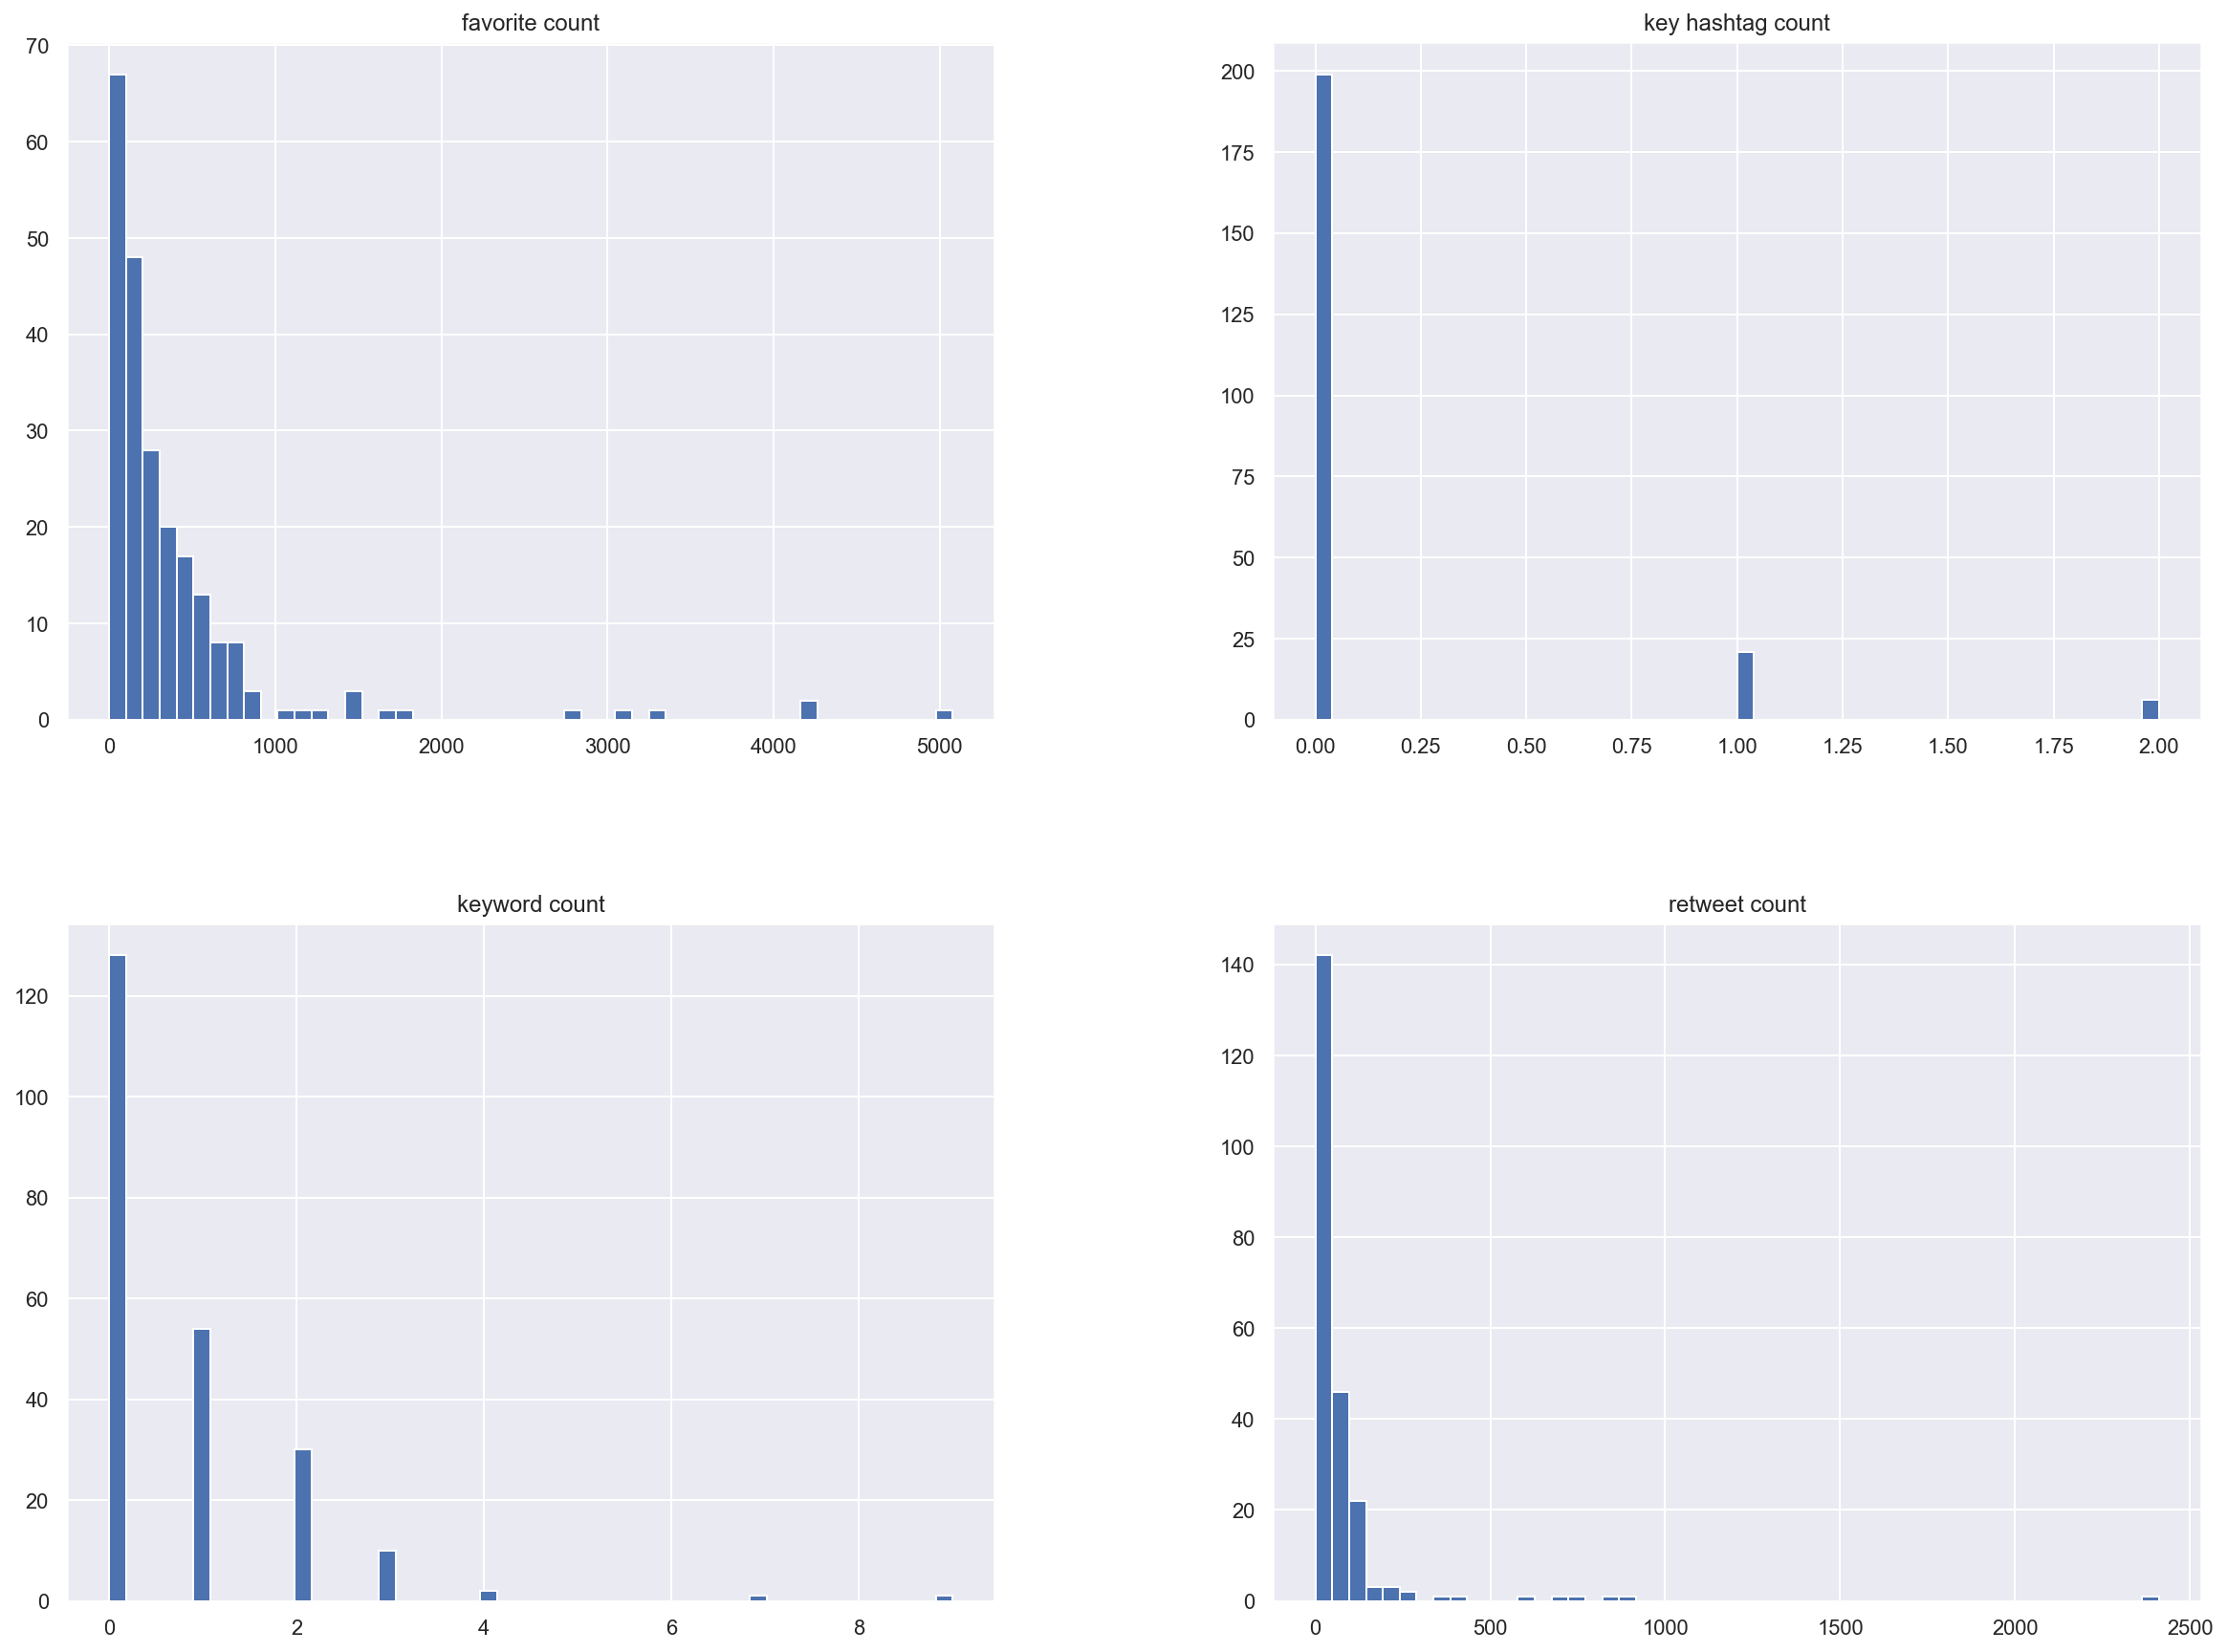

In [358]:
X_df.hist(bins=50, figsize=(20,15))
plt.show()

In [368]:
# top retweet counts
print(X_df.sort_values('retweet count', ascending=False).head(10))

     retweet count  favorite count  key hashtag count  keyword count
72            2411            4179                  0              1
0              908            3261                  0              2
73             838            4217                  0              1
74             756            5077                  0              0
61             677            2780                  0              2
119            623            3057                  0              0
93             412            1781                  0              2
79             345            1422                  0              0
23             272            1461                  0              0
167            271            1247                  0              2


In [369]:
# top favorite counts
print(X_df.sort_values('favorite count', ascending=False).head(10))

     retweet count  favorite count  key hashtag count  keyword count
74             756            5077                  0              0
73             838            4217                  0              1
72            2411            4179                  0              1
0              908            3261                  0              2
119            623            3057                  0              0
61             677            2780                  0              2
93             412            1781                  0              2
51             240            1671                  0              9
23             272            1461                  0              0
63             121            1433                  0              1


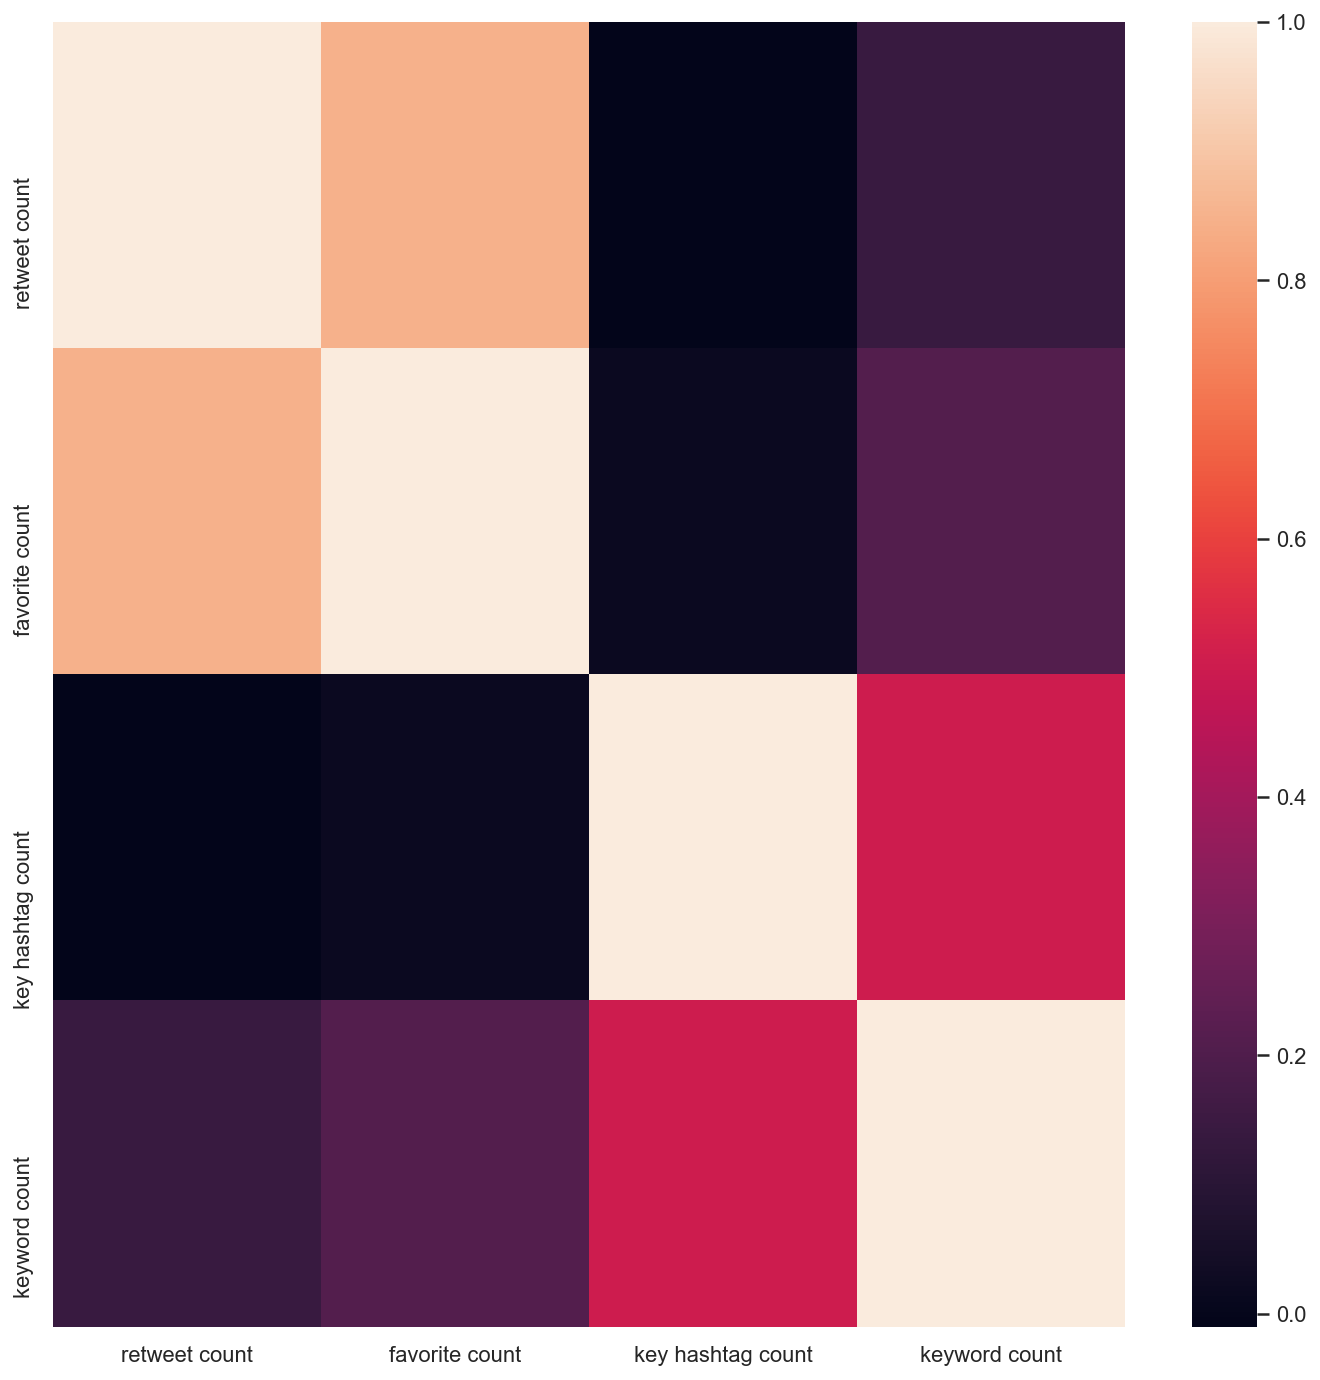

In [360]:
sns.set(rc={'figure.figsize':(12,12)})
correlation_matrix = X_df.corr().round(2)
sns.heatmap(correlation_matrix) #annot=True
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F0B46E0AC8>,
      dtype=object)

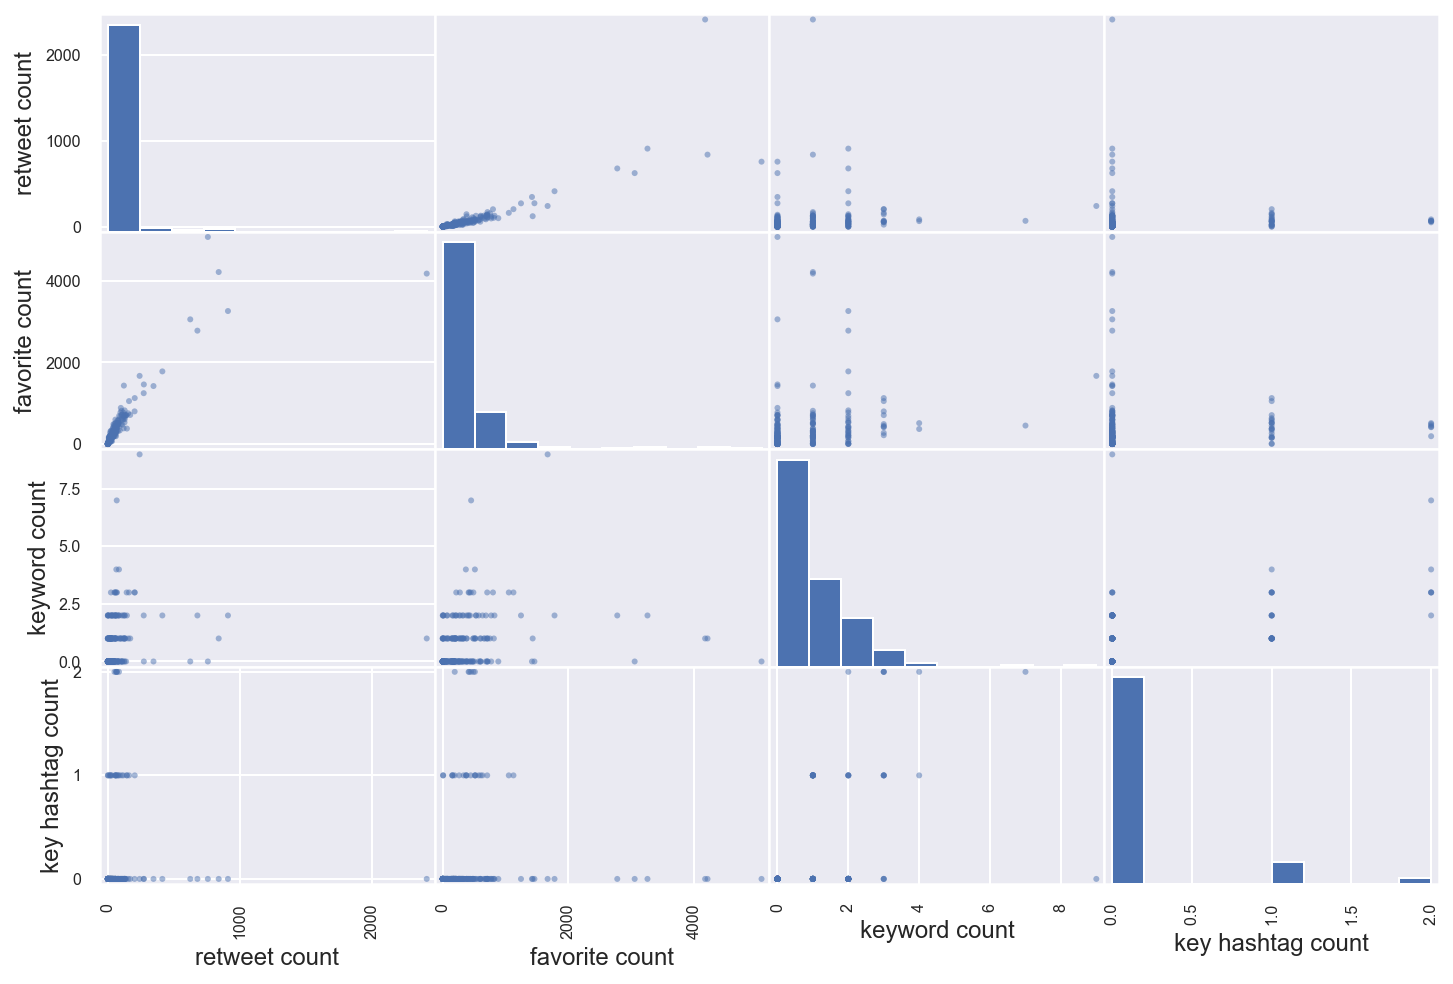

In [361]:
# correlation plots
from pandas.plotting import scatter_matrix
scatter_matrix(X_df[['retweet count', 'favorite count','keyword count', 'key hashtag count']], figsize=(12, 8))

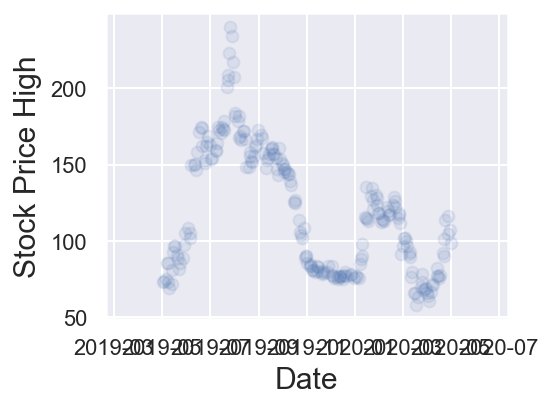

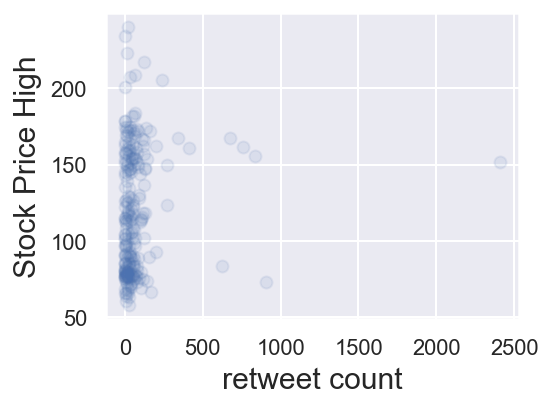

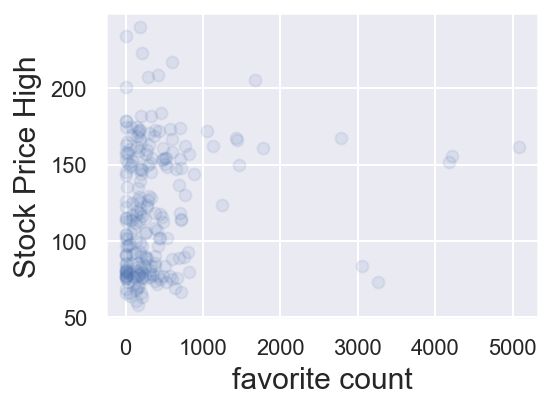

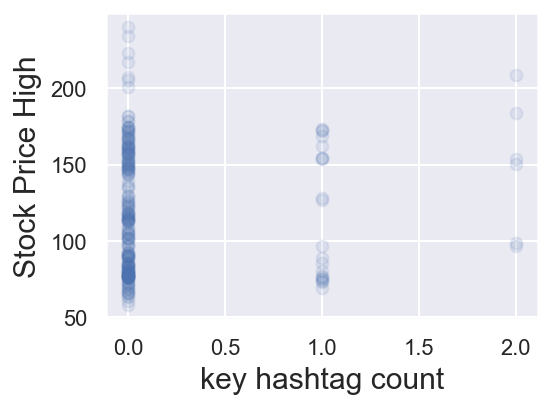

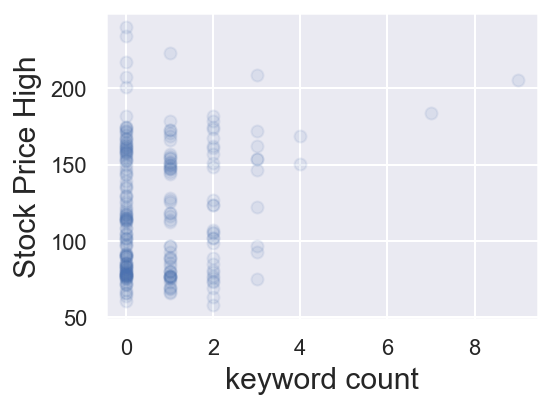

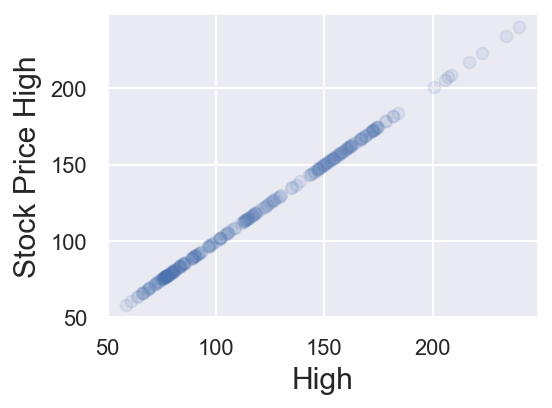

In [362]:
# scatter plot relative to the target (stock price)
for feature_name in df1.columns:
    plt.figure(figsize=(4, 3))
    plt.scatter(df1[feature_name], y, alpha=0.1)
    plt.ylabel('Stock Price High', size=15)
    plt.xlabel(feature_name, size=15)
    plt.tight_layout()

In [435]:
df1.head()

,Date,retweet count,favorite count,key hashtag count,keyword count,High
0,2019-05-02,908,3261,0,2,72.949997
1,2019-05-03,144,379,1,2,74.000000
2,2019-05-06,117,606,1,1,74.839996
3,2019-05-07,3,66,0,0,85.449997
4,2019-05-08,26,159,0,0,85.379997


# to reaload the data (can be deleted)

In [855]:
# from datafram to array (w/d "Date" column)
X_full = df1[['retweet count','favorite count','key hashtag count','keyword count']].to_numpy()
X_full.shape
# from datafram to array
Y_full = df1['High'].to_numpy()
Y_full.shape
X_df=pd.DataFrame(X_full, columns=['retweet count','favorite count','key hashtag count','keyword count'])
X_df.head()

,retweet count,favorite count,key hashtag count,keyword count
0,908,3261,0,2
1,144,379,1,2
2,117,606,1,1
3,3,66,0,0
4,26,159,0,0


drop some labeled observations

In [856]:
mask = np.logical_or.reduce((X_full[:,0]>100, # MIN retweet count
                             X_full[:,1]>500, # MIN favorite count
                             X_full[:,2]>0, # MIN key hashtag count
                             X_full[:,3]>0)) # MIN keyword count

In [857]:
# Drop the observations 
Y_full=Y_full[mask==True]
X_full=X_full[mask==True]
X_df=X_df[mask==True]

In [858]:
X_full.shape

(114, 4)

In [859]:
# Removing outliner
mask2 = X_full[:,0]<500 # MAX retweet count
Y_full=Y_full[mask2==True]
X_full=X_full[mask2==True]
X_df=X_df[mask2==True]

In [860]:
X_full.shape

(108, 4)

In [861]:
# Removing outliner
mask3 = X_full[:,1]<1000 # MAX favorite count
Y_full=Y_full[mask3==True]
X_full=X_full[mask3==True]
X_df=X_df[mask3==True]

In [862]:
X_full.shape

(100, 4)

In [863]:
# Removing outliner
mask3 = X_full[:,3]<5 # MAX keyword count
Y_full=Y_full[mask3==True]
X_full=X_full[mask3==True]
X_df=X_df[mask3==True]

In [864]:
X_full.shape

(99, 4)

In [865]:
Y_full.shape

(99,)

In [866]:
X_df.shape

(99, 4)

### Split train test sets 

In [867]:
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full,test_size=0.2, random_state=1)

In [868]:
print("train data", X_train.shape, y_train.shape)
print("test data", X_test.shape,  y_test.shape)

train data (79, 4) (79,)
test data (20, 4) (20,)


In [869]:
# create benchmark
bench = int(len(Y_full)*0.8) # 80% of the data

# for the Y_full variable
y_train2 = Y_full[:bench]
y_test2 = Y_full[bench:]

# for the X_full variable
X_train2 = X_full[:bench]
X_test2 = X_full[bench:]

#### Feature Scaling
Most common scaling methods: 
- **standardization**= normalization by substracting the mean and dividing by the standard deviation (values are not bounded)
- **Min-max scaling**= normalization by substracting the minimum and dividing by the maximum (values between `0` and `1`)

In [870]:
# for random splitting
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# for temporal split
scaler2 = StandardScaler().fit(X_train2)
X_train2_scaled = scaler.transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

## Linear regression

### Linear Regression - Randomized Splitting

In [942]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [943]:
# randomized splitting
# use non standardized data for randomized splitting:
lin_reg.fit(X_train, y_train)
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train, y_train), 2)))

R-squared for training dataset:0.02


In [944]:
# randomized splitting
# use standardized data for randomized splitting: 
lin_reg.fit(X_train_scaled, y_train)
print("R-squared for training dataset & scaled features:{}".
      format(np.round(lin_reg.score(X_train_scaled, y_train), 2)))

R-squared for training dataset & scaled features:0.02


In [945]:
features = list(X_df.columns)

print('The coefficients of the features from the linear model:')
print(dict(zip(features, [round(x, 2) for x in lin_reg.coef_])))

The coefficients of the features from the linear model:
{'retweet count': -8.99, 'favorite count': 11.71, 'key hashtag count': -0.63, 'keyword count': 1.19}


#### Mean squared log error

In [877]:
from sklearn.metrics import mean_squared_error
# randomized splitting
# in-sample performance
y_train_pred = lin_reg.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
print("RMS: %s" % train_rmse) # = np.sqrt(np.mean((predicted - expected) ** 2))

RMS: 66.02406891010023


In [878]:
# randomized splitting
# out-of-sample performance
y_test_pred = lin_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("RMS: %s" % test_rmse) 

RMS: 58.57367721052237


#### Explained variance and $r^2$-score:

In [881]:
from sklearn.metrics import r2_score
# randomized splitting
r2=round(r2_score(y_test, y_test_pred), 2)
print("R2: %s" % r2)

R2: -1.16


In [882]:
from sklearn.metrics import explained_variance_score
exp_var = round(explained_variance_score(y_test,y_test_pred),2)
print("Explained variance: %s" % exp_var)

Explained variance: -1.15


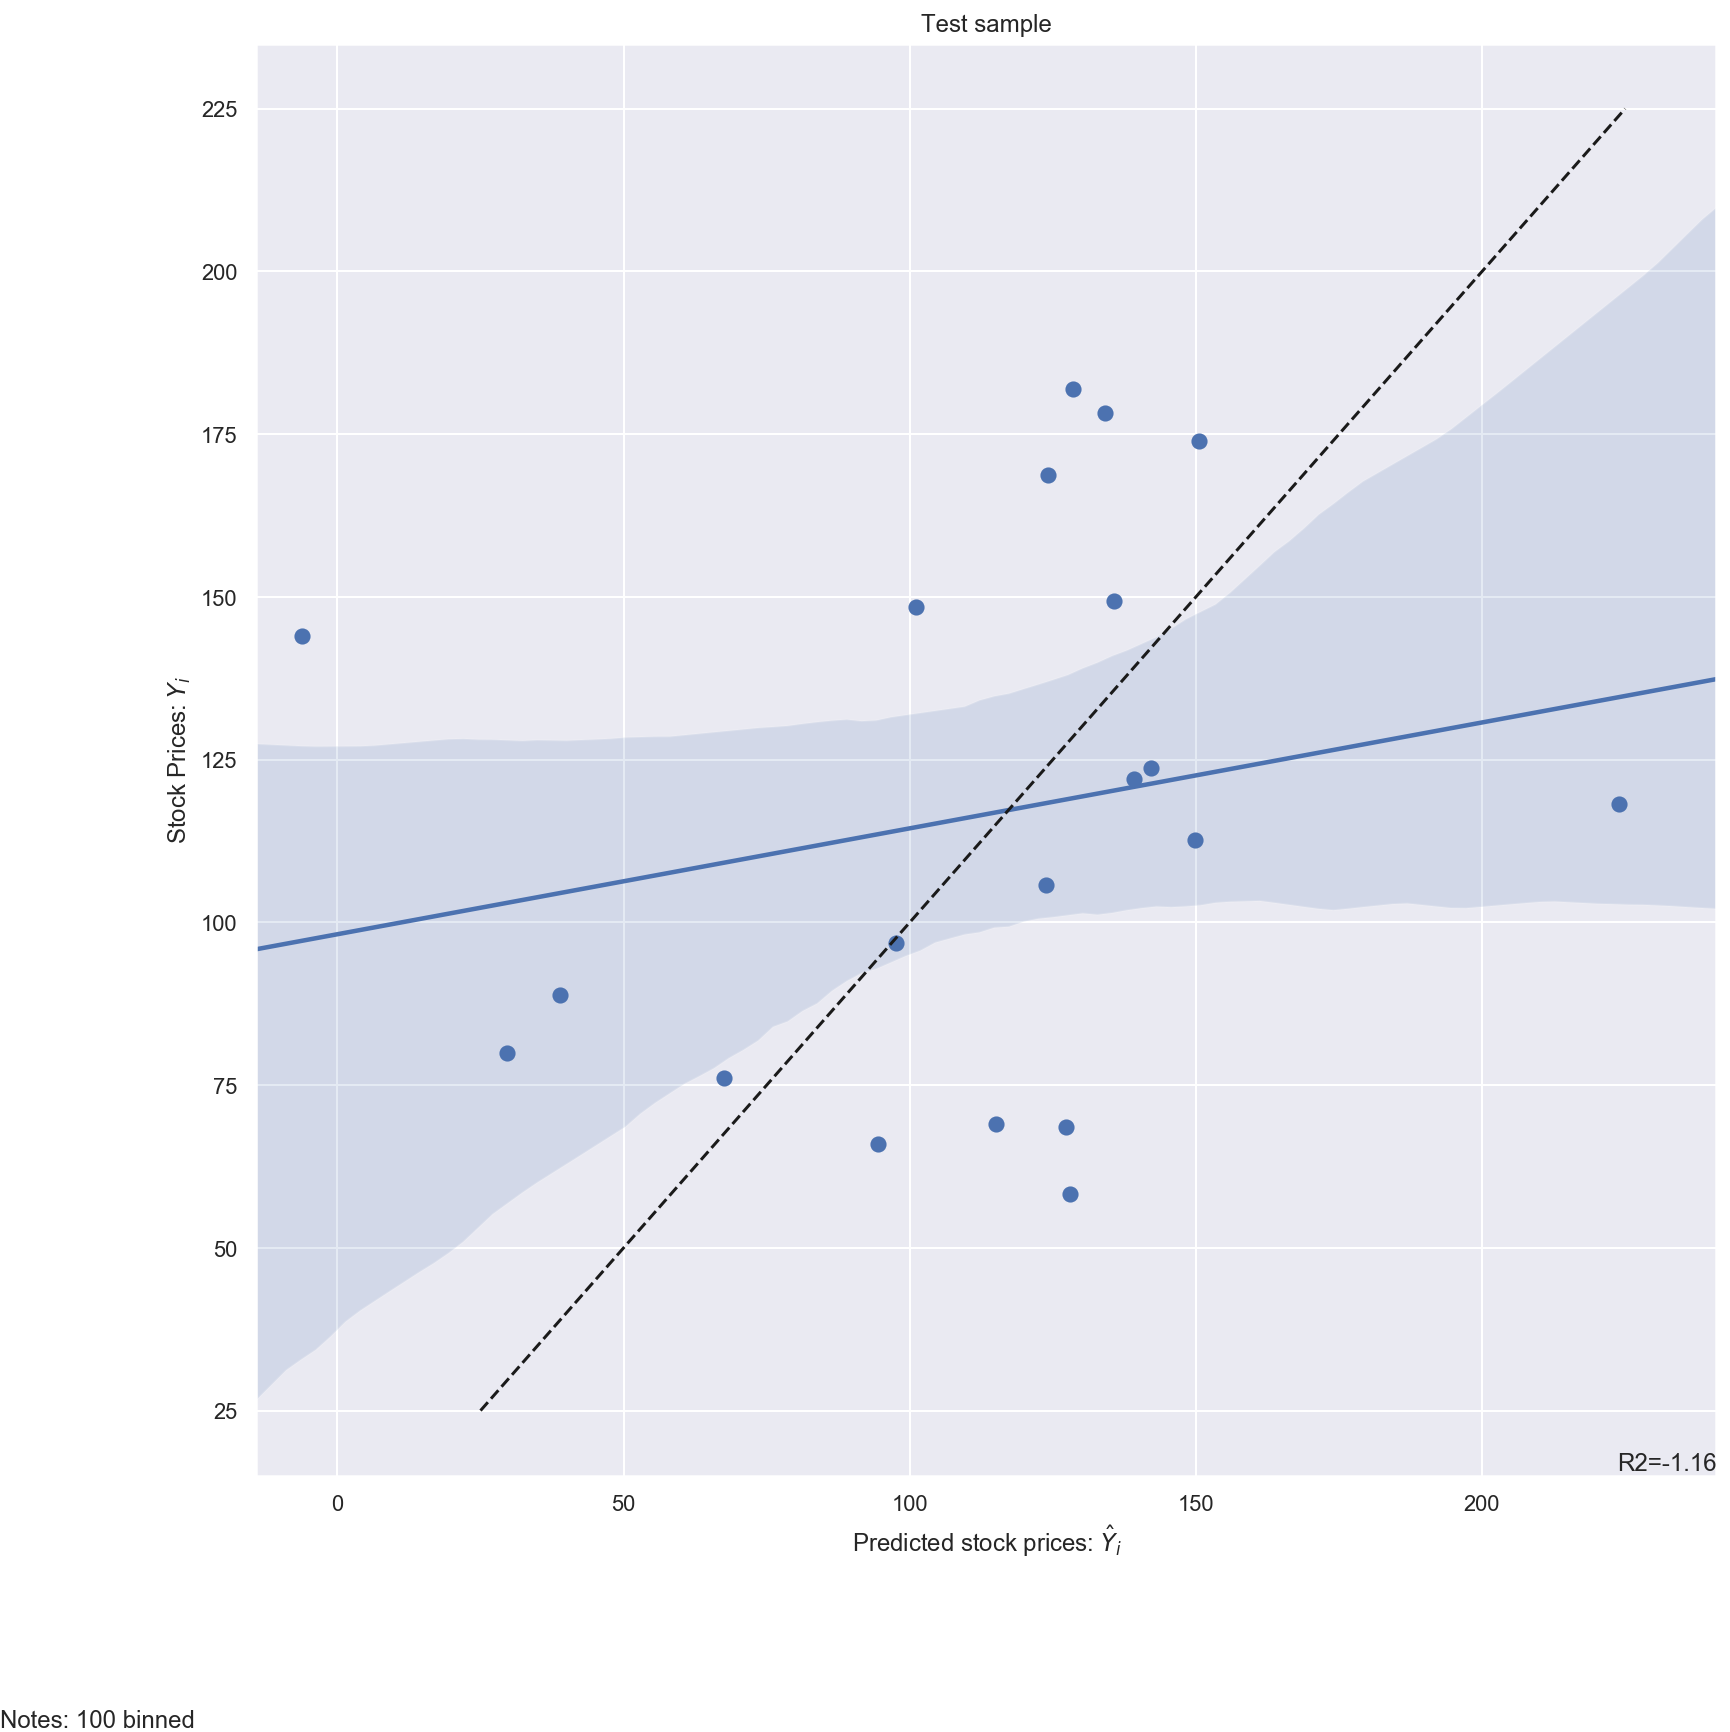

In [886]:
# Regplot
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([25, 225], [25, 225], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

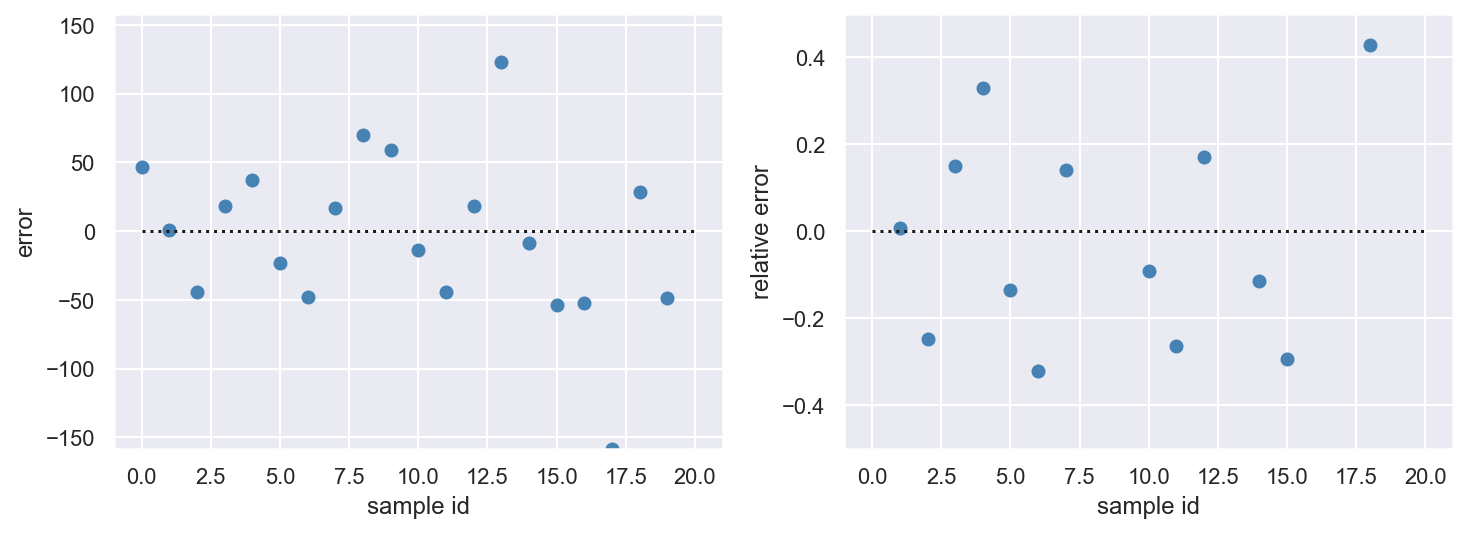

In [887]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
def plot_fit_quality(values_test, predicted):
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)

    x = np.arange(len(predicted))
    plt.scatter(x, predicted - values_test, color='steelblue', marker='o') 

    plt.plot([0, len(predicted)], [0, 0], "k:")
    
    max_diff = np.max(np.abs(predicted - values_test))
    plt.ylim([-max_diff, max_diff])
    
    plt.ylabel("error")
    plt.xlabel("sample id")

    plt.subplot(1, 2, 2)

    plt.scatter(x, (predicted - values_test) / values_test, color='steelblue', marker='o') 
    plt.plot([0, len(predicted)], [0, 0], "k:")
    plt.ylim([-.5, .5])
      
    plt.ylabel("relative error")
    plt.xlabel("sample id")

plot_fit_quality(y_test, y_test_pred)

### Linear Regression - Temporal Splitting

In [947]:
# temporal splitting
# use non standardized data for temporal split:
lin_reg.fit(X_train2, y_train2)
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train2, y_train2), 2)))

R-squared for training dataset:0.01


In [948]:
# temporal splitting
# use standardized data for temporal split:
lin_reg.fit(X_train2_scaled, y_train2)
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train2_scaled, y_train2), 2)))

R-squared for training dataset:0.01


In [949]:
features = list(X_num.columns)

print('The coefficients of the features from the linear model:')
print(dict(zip(features, [round(x, 2) for x in lin_reg.coef_])))

The coefficients of the features from the linear model:
{'retweet count': 2.28, 'favorite count': -0.41, 'key hashtag count': -2.64, 'keyword count': 1.67}


#### Mean squared log error

In [950]:
# temporal splitting
# in-sample performance
y_train2_pred = lin_reg.predict(X_train2)
train2_mse = mean_squared_error(y_train2, y_train2_pred)
train2_rmse = np.sqrt(train2_mse)
print("RMS: %s" % train2_rmse) # = np.sqrt(np.mean((predicted - expected) ** 2))

RMS: 66.69657008918907


In [951]:
# temporal splitting
# out-of-sample performance
y_test2_pred = lin_reg.predict(X_test2)        
test2_mse = mean_squared_error(y_test2, y_test2_pred)
test2_rmse = np.sqrt(test2_mse)
print("RMS: %s" % test2_rmse) 

RMS: 55.48260318701262


#### Explained variance and $r^2$-score:

In [952]:
# temporal splitting
r2=round(r2_score(y_test2, y_test2_pred), 2)
print("R2: %s" % r2)

R2: -5.4


In [953]:
exp_var = round(explained_variance_score(y_test2,y_test2_pred),2)
print("Explained variance: %s" % exp_var)

Explained variance: -2.5


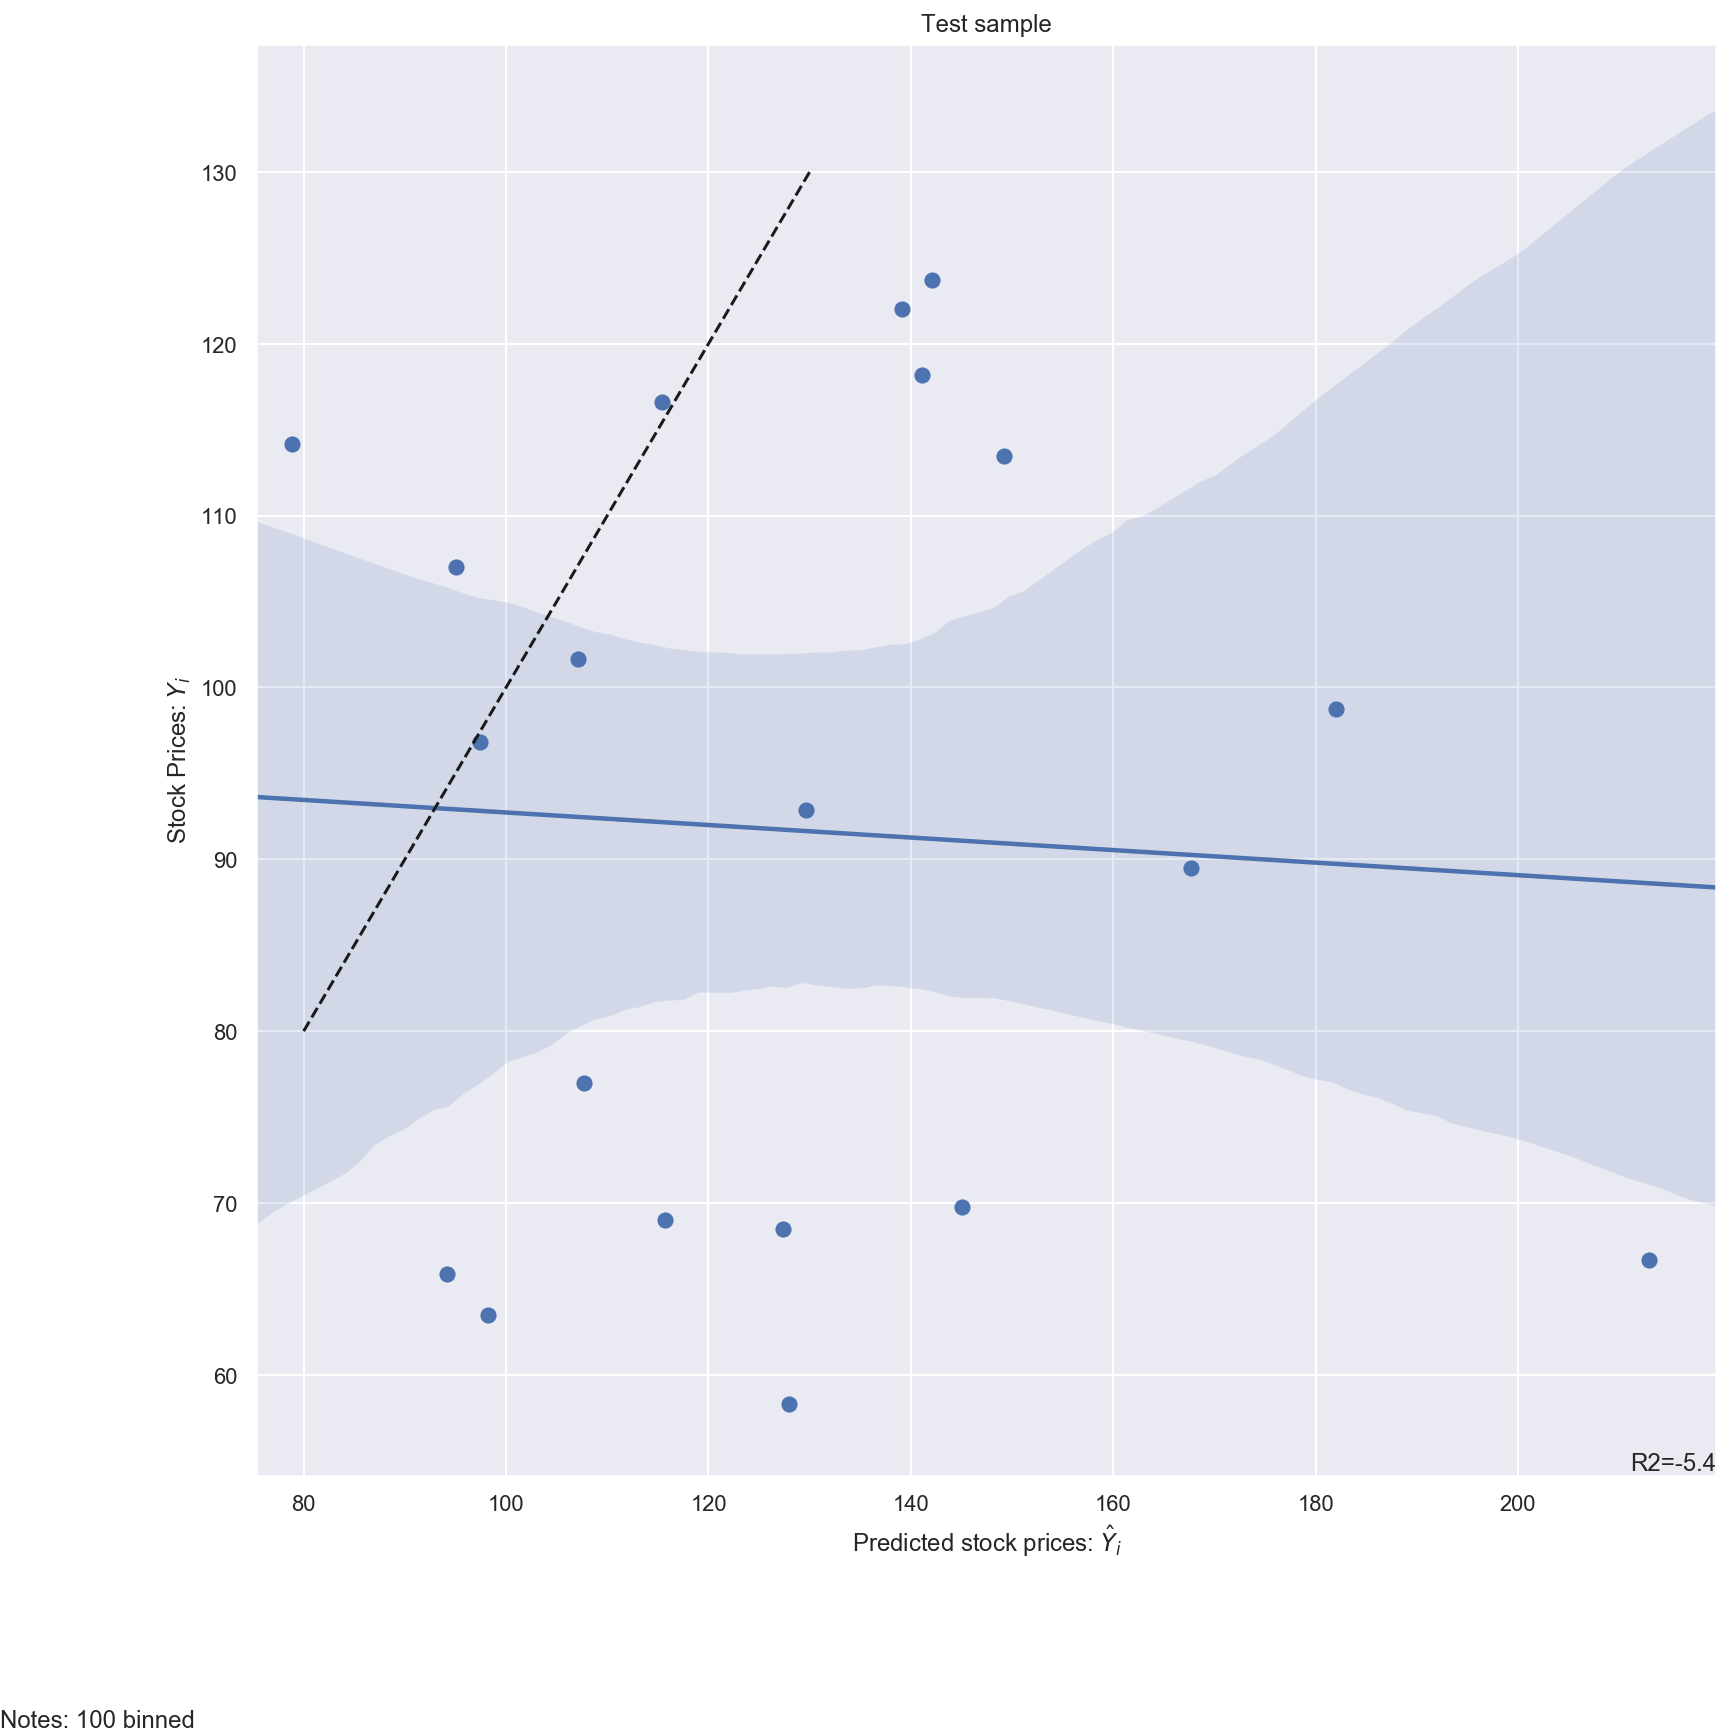

In [954]:
# Regplot
g=sns.regplot(x= y_test2_pred, y=y_test2, x_bins= 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([80, 130], [80, 130], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

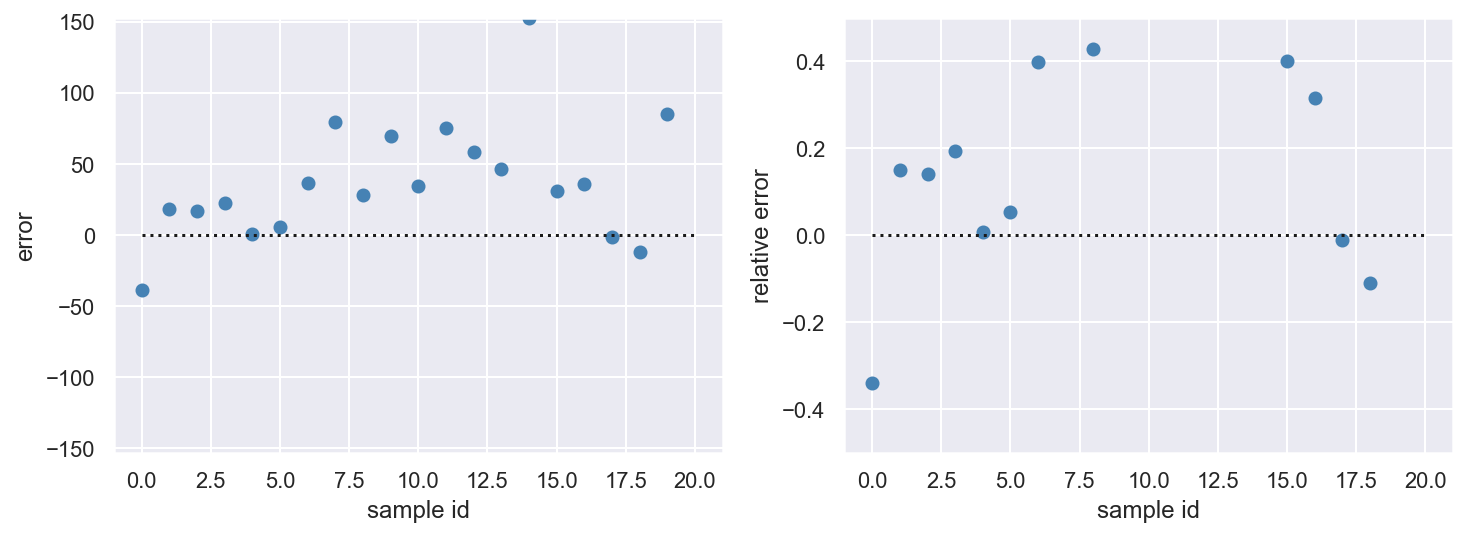

In [955]:
#Let us plot how good given and predicted values match on the training data set 
plot_fit_quality(y_test2, y_test2_pred)

## Ridge Regression

### Ridge Regression - Randomized Splitting

In [894]:
# randomized splitting
ridge_reg=Ridge(alpha=1)       
ridge_reg.fit(X_train, y_train)

y_train_pred=ridge_reg.predict(X_train)
y_test_pred = ridge_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 4)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 4)) 

train RMS: 66.02406891010023
test RMS: 41.01179669221842
train R2: 0.0183
test R2: -0.057


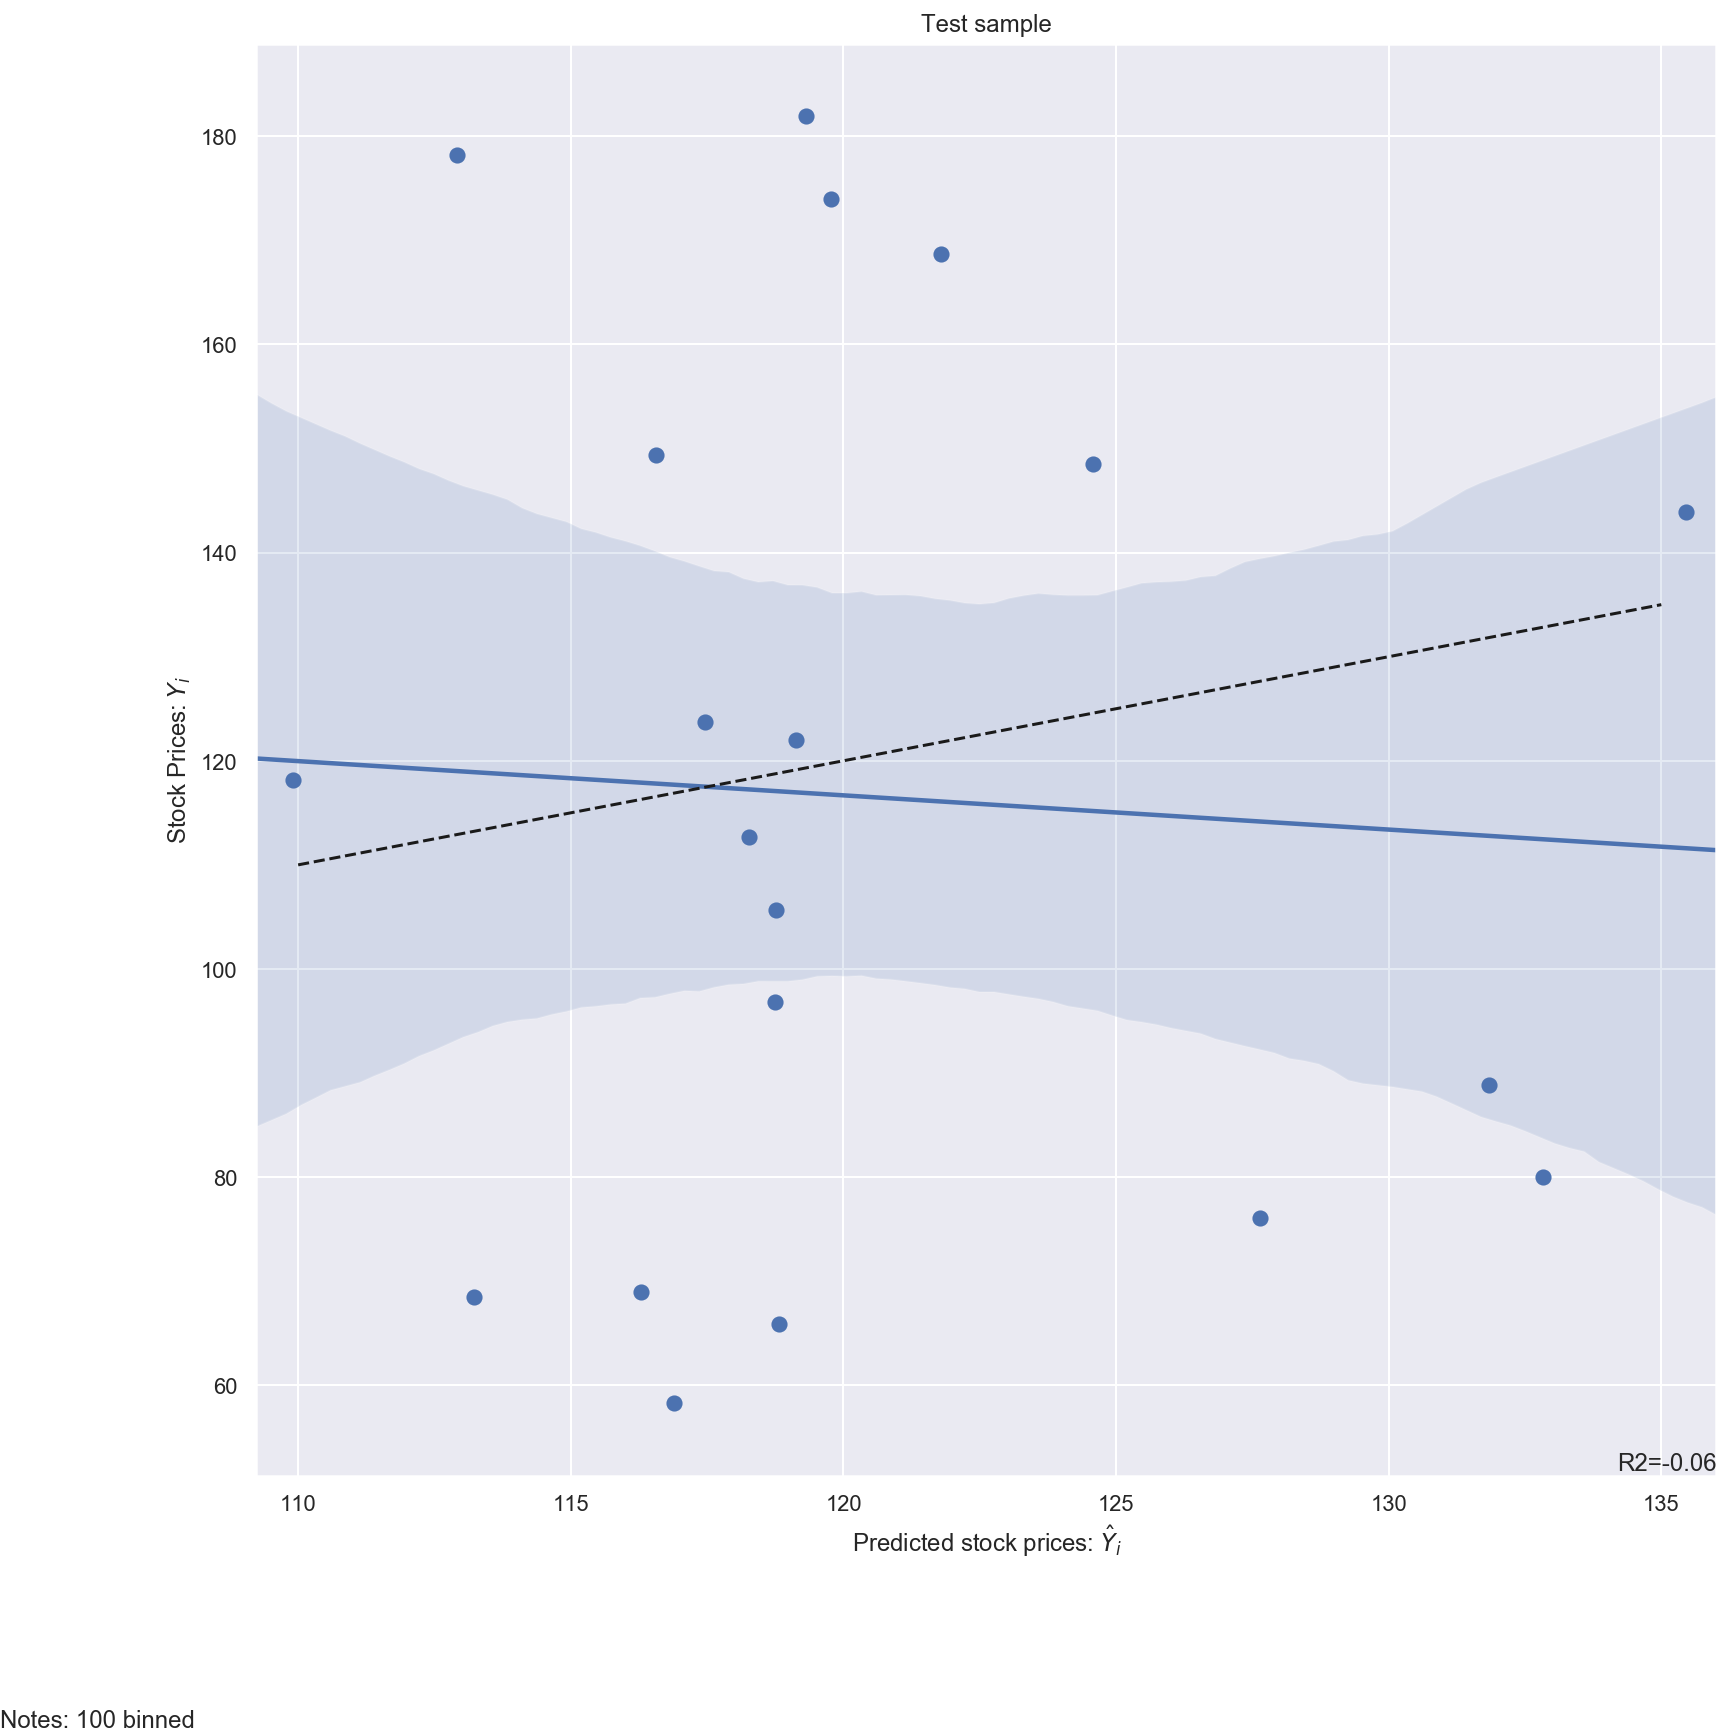

In [896]:
# randomized splitting
r2 = r2=round(r2_score(y_test, y_test_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([110, 135], [110, 135], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

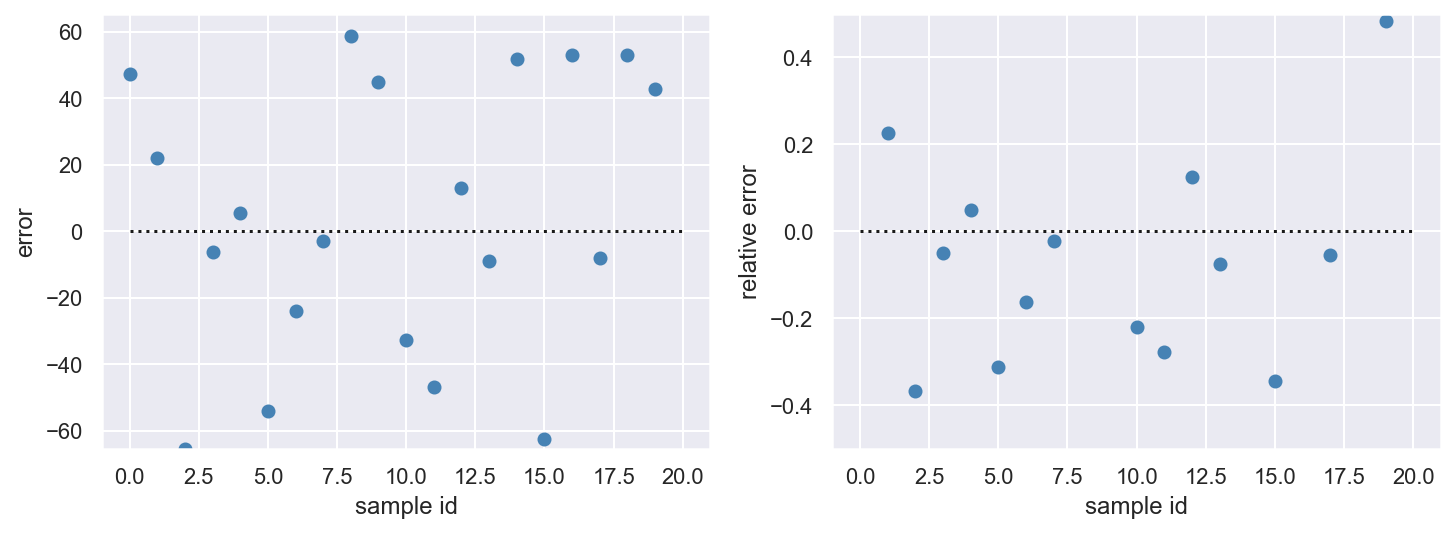

In [897]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test, y_test_pred)

### Ridge Regression - Temporal Splitting

In [931]:
# temporal splitting
ridge_reg.fit(X_train2, y_train2)

y_train2_pred=ridge_reg.predict(X_train2)
y_test2_pred = ridge_reg.predict(X_test2)        
test2_mse = mean_squared_error(y_test2, y_test2_pred)
test2_rmse = np.sqrt(test2_mse)
print("train RMS: %s" % train2_rmse) 
print("test RMS: %s" % test2_rmse) 
print("train R2: %s" % round(r2_score(y_train2, y_train2_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test2, y_test2_pred), 2)) 

train RMS: 66.69657008918907
test RMS: 41.151143841093656
train R2: 0.01
test R2: -2.52


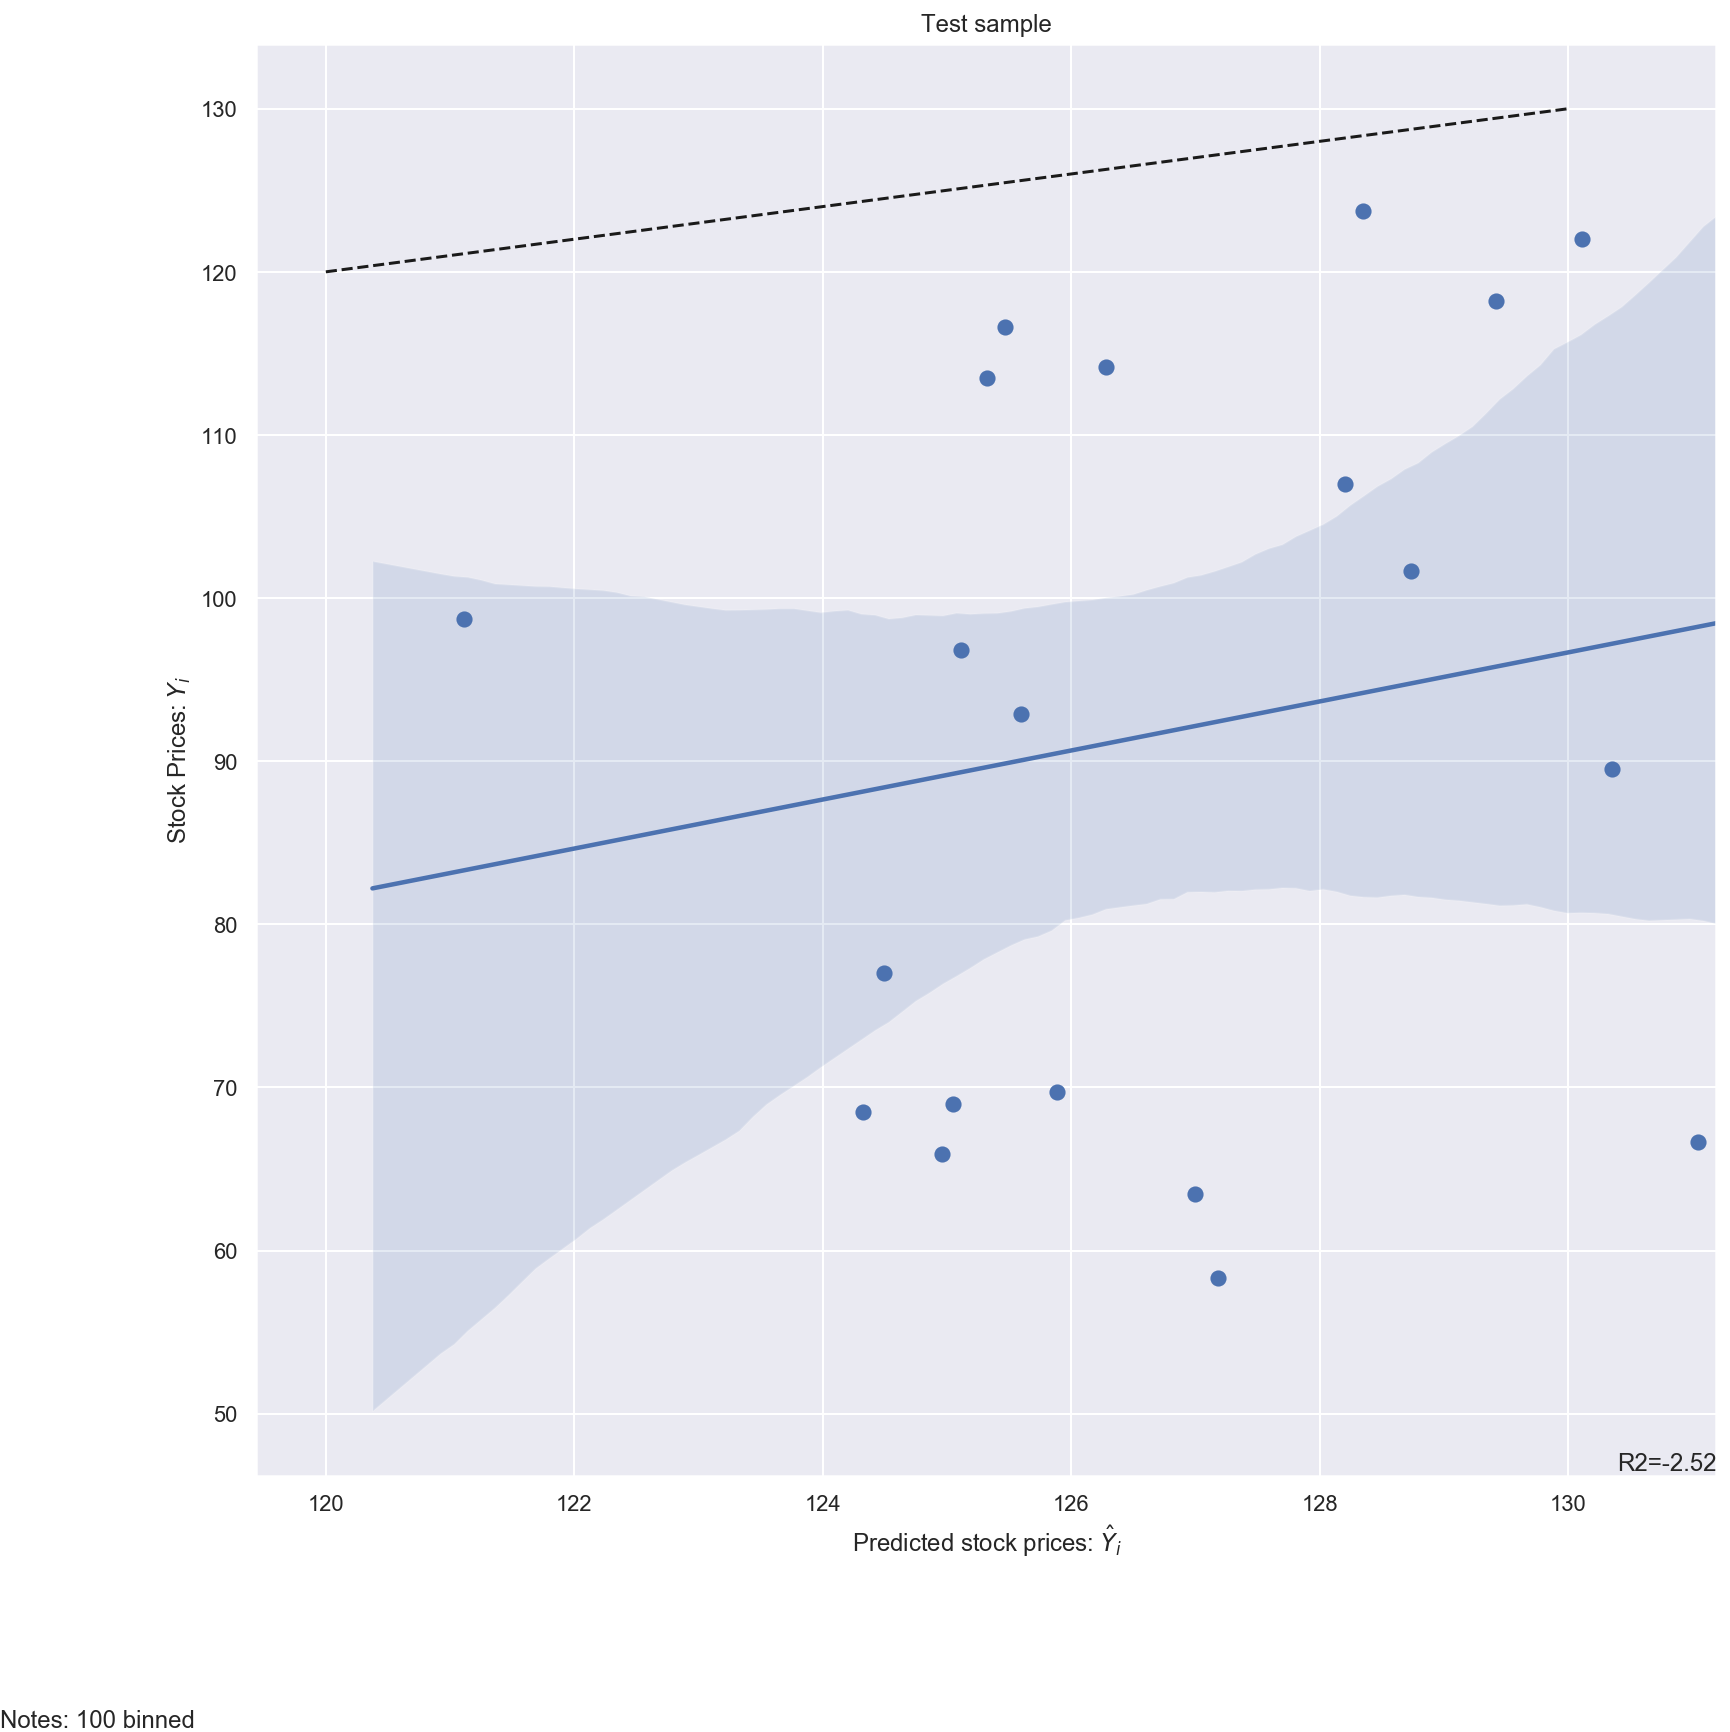

In [900]:
# temporal splitting
r2 = r2=round(r2_score(y_test2, y_test2_pred), 2)

# Regplot
g=sns.regplot(x= y_test2_pred, y=y_test2, x_bins= 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([120, 130], [120, 130], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

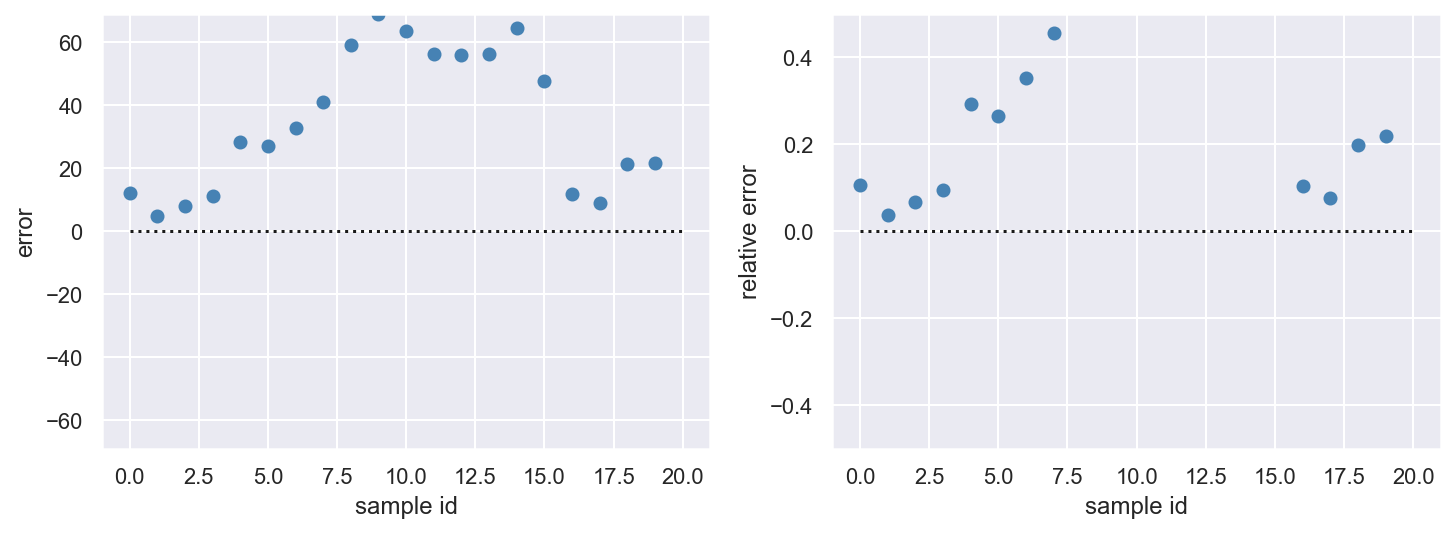

In [901]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test2, y_test2_pred)

## Polynomial Regression

In [902]:
poly_features=PolynomialFeatures(degree=2)

### Polynomial Regression - Randomized Splitting

In [903]:
# randomized splitting
X_train_poly=poly_features.fit_transform(X_train)
X_test_poly=poly_features.fit_transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

y_test_pred = lin_reg.predict(X_test_poly)
test_rmse = mean_squared_error(y_test,y_test_pred)
test_rmse = np.sqrt(test_rmse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2))

test RMS: 39.699739915160265
train R2: 0.02
test R2: 0.01


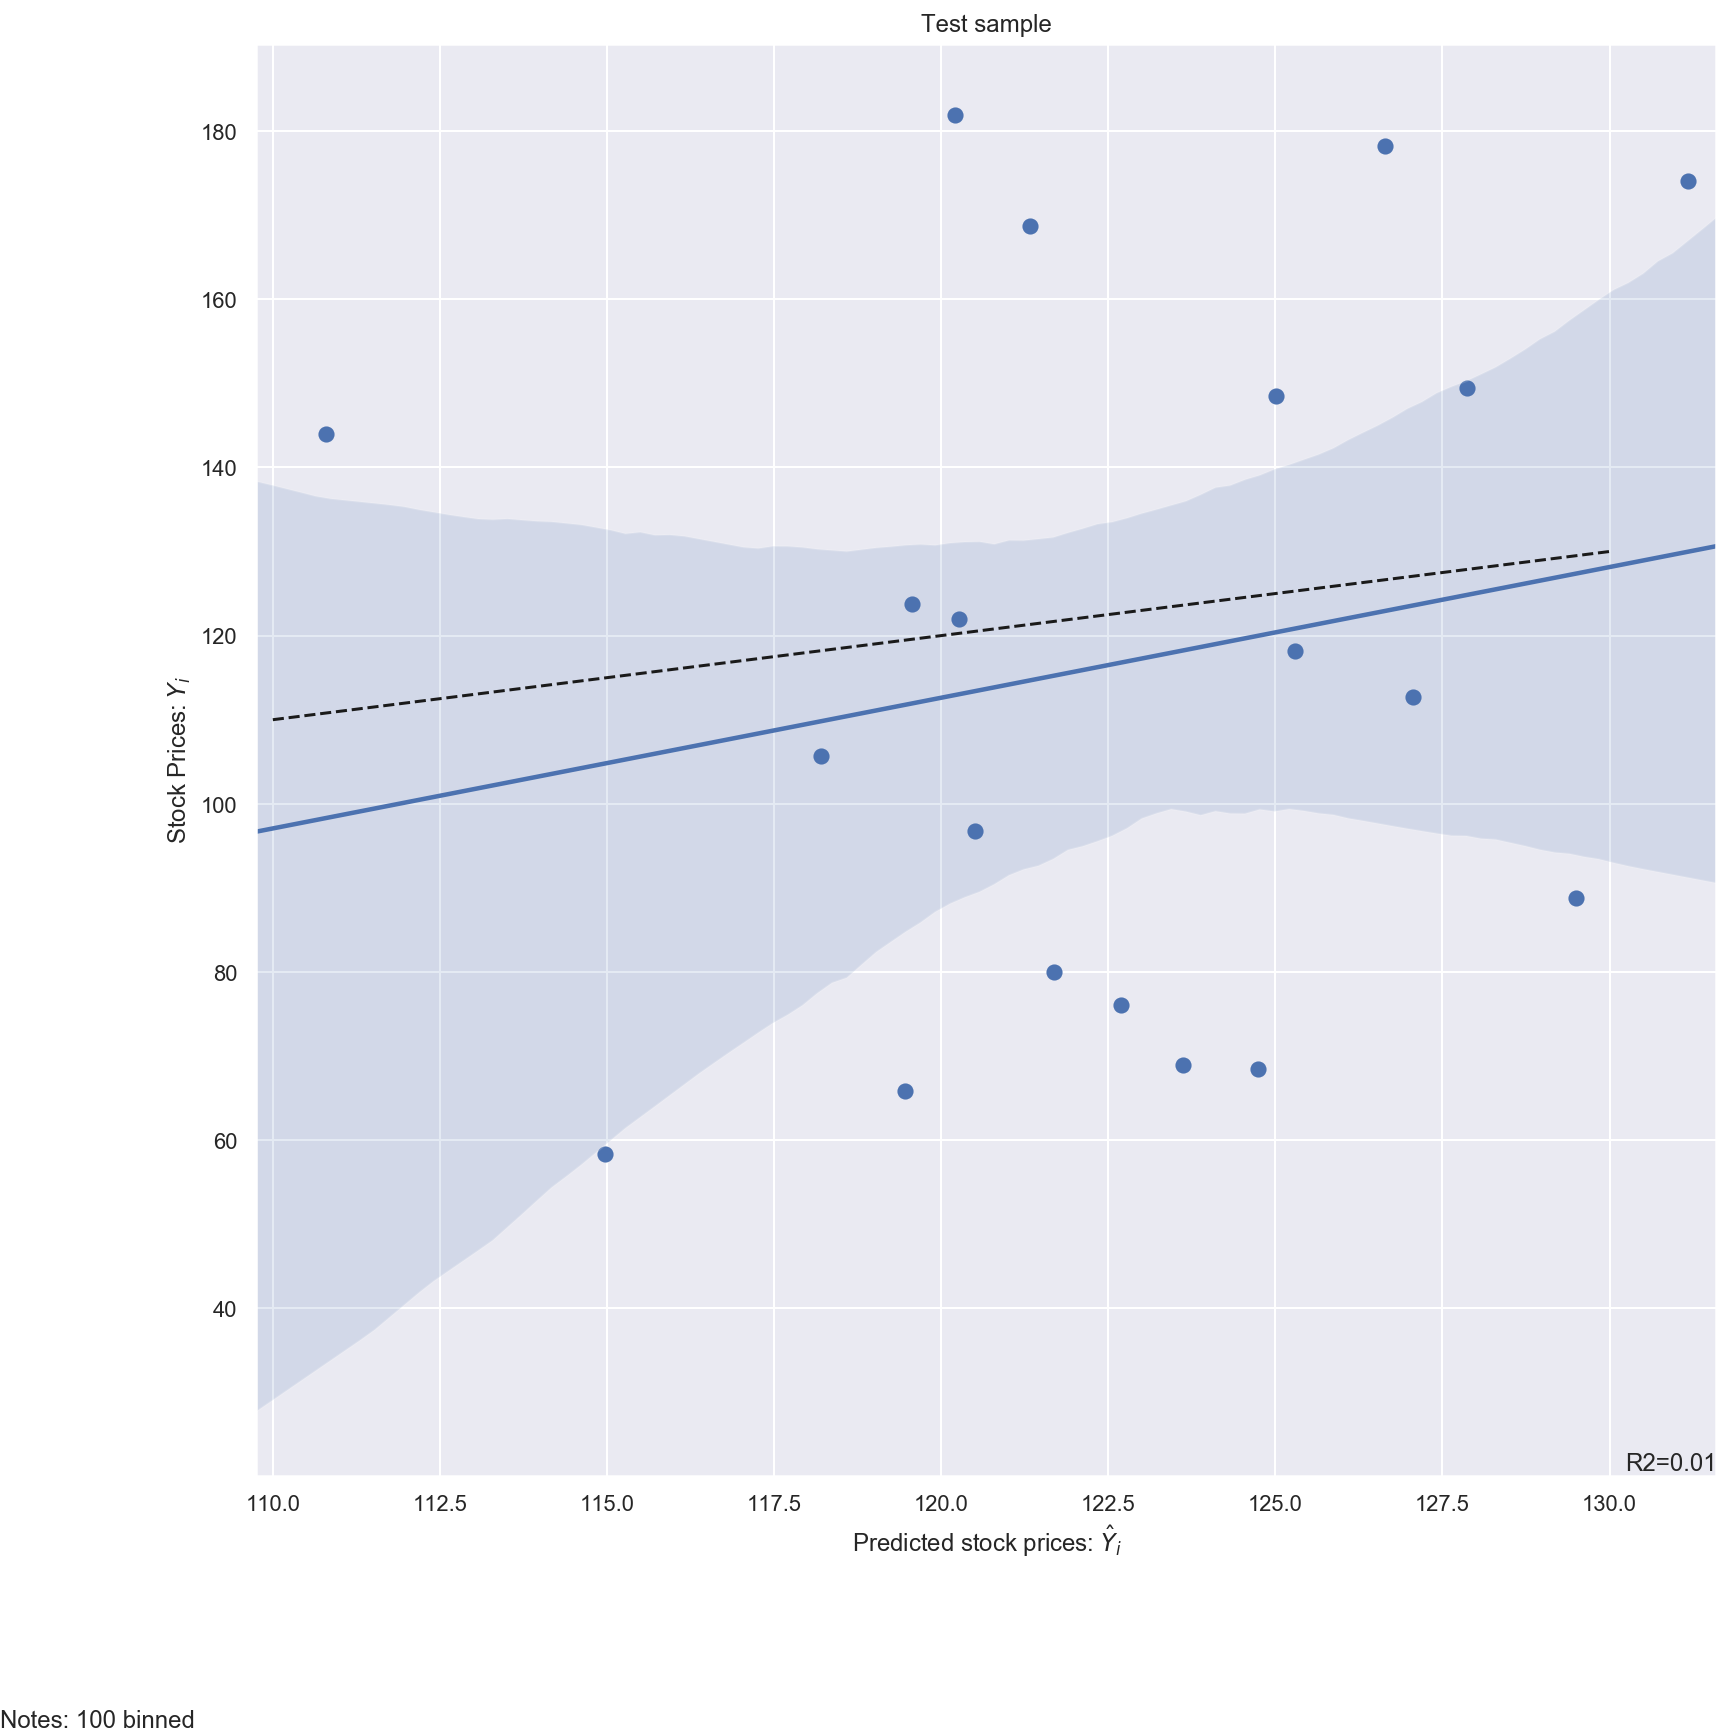

In [906]:
# randomized splitting
r2 = r2=round(r2_score(y_test, y_test_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([110, 130], [110, 130], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

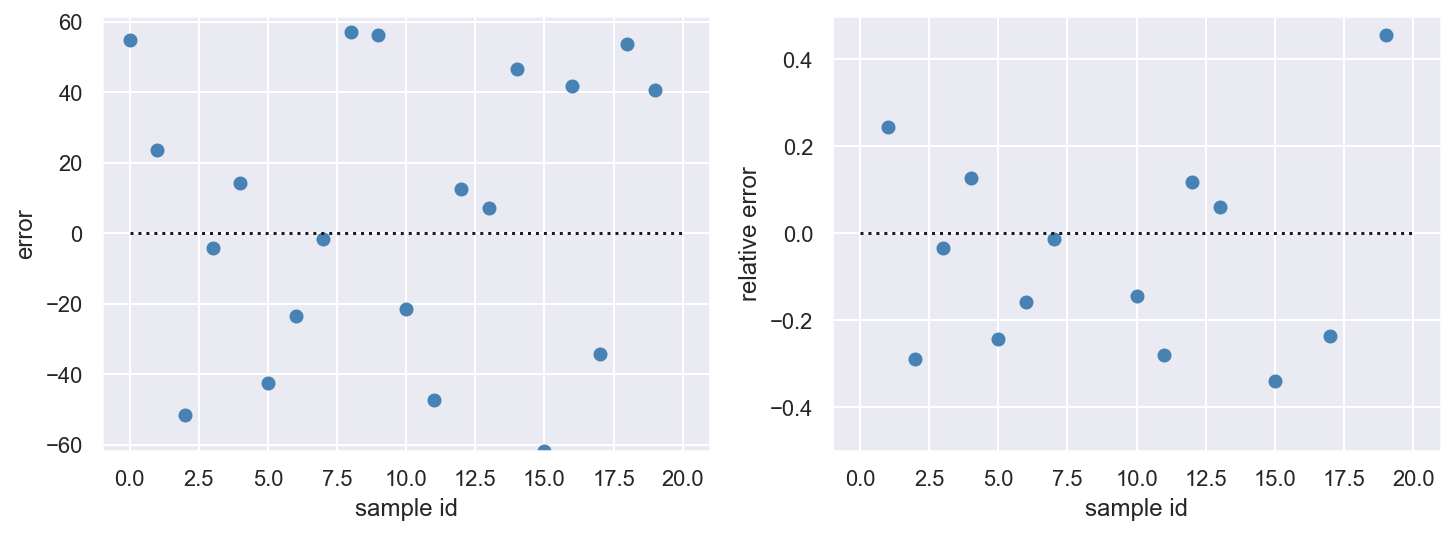

In [907]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test, y_test_pred)

### Polynomial Regression - Temporal Splitting

In [908]:
# temporal splitting
X_train2_poly=poly_features.fit_transform(X_train2)
X_test2_poly=poly_features.fit_transform(X_test2)

lin_reg = LinearRegression()
lin_reg.fit(X_train2_poly, y_train2)

y_test2_pred = lin_reg.predict(X_test2_poly)
test_rmse = mean_squared_error(y_test2,y_test2_pred)
test_rmse = np.sqrt(test_rmse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train2, y_train2_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test2, y_test2_pred), 2))

test RMS: 44.83037539369807
train R2: 0.01
test R2: -3.18


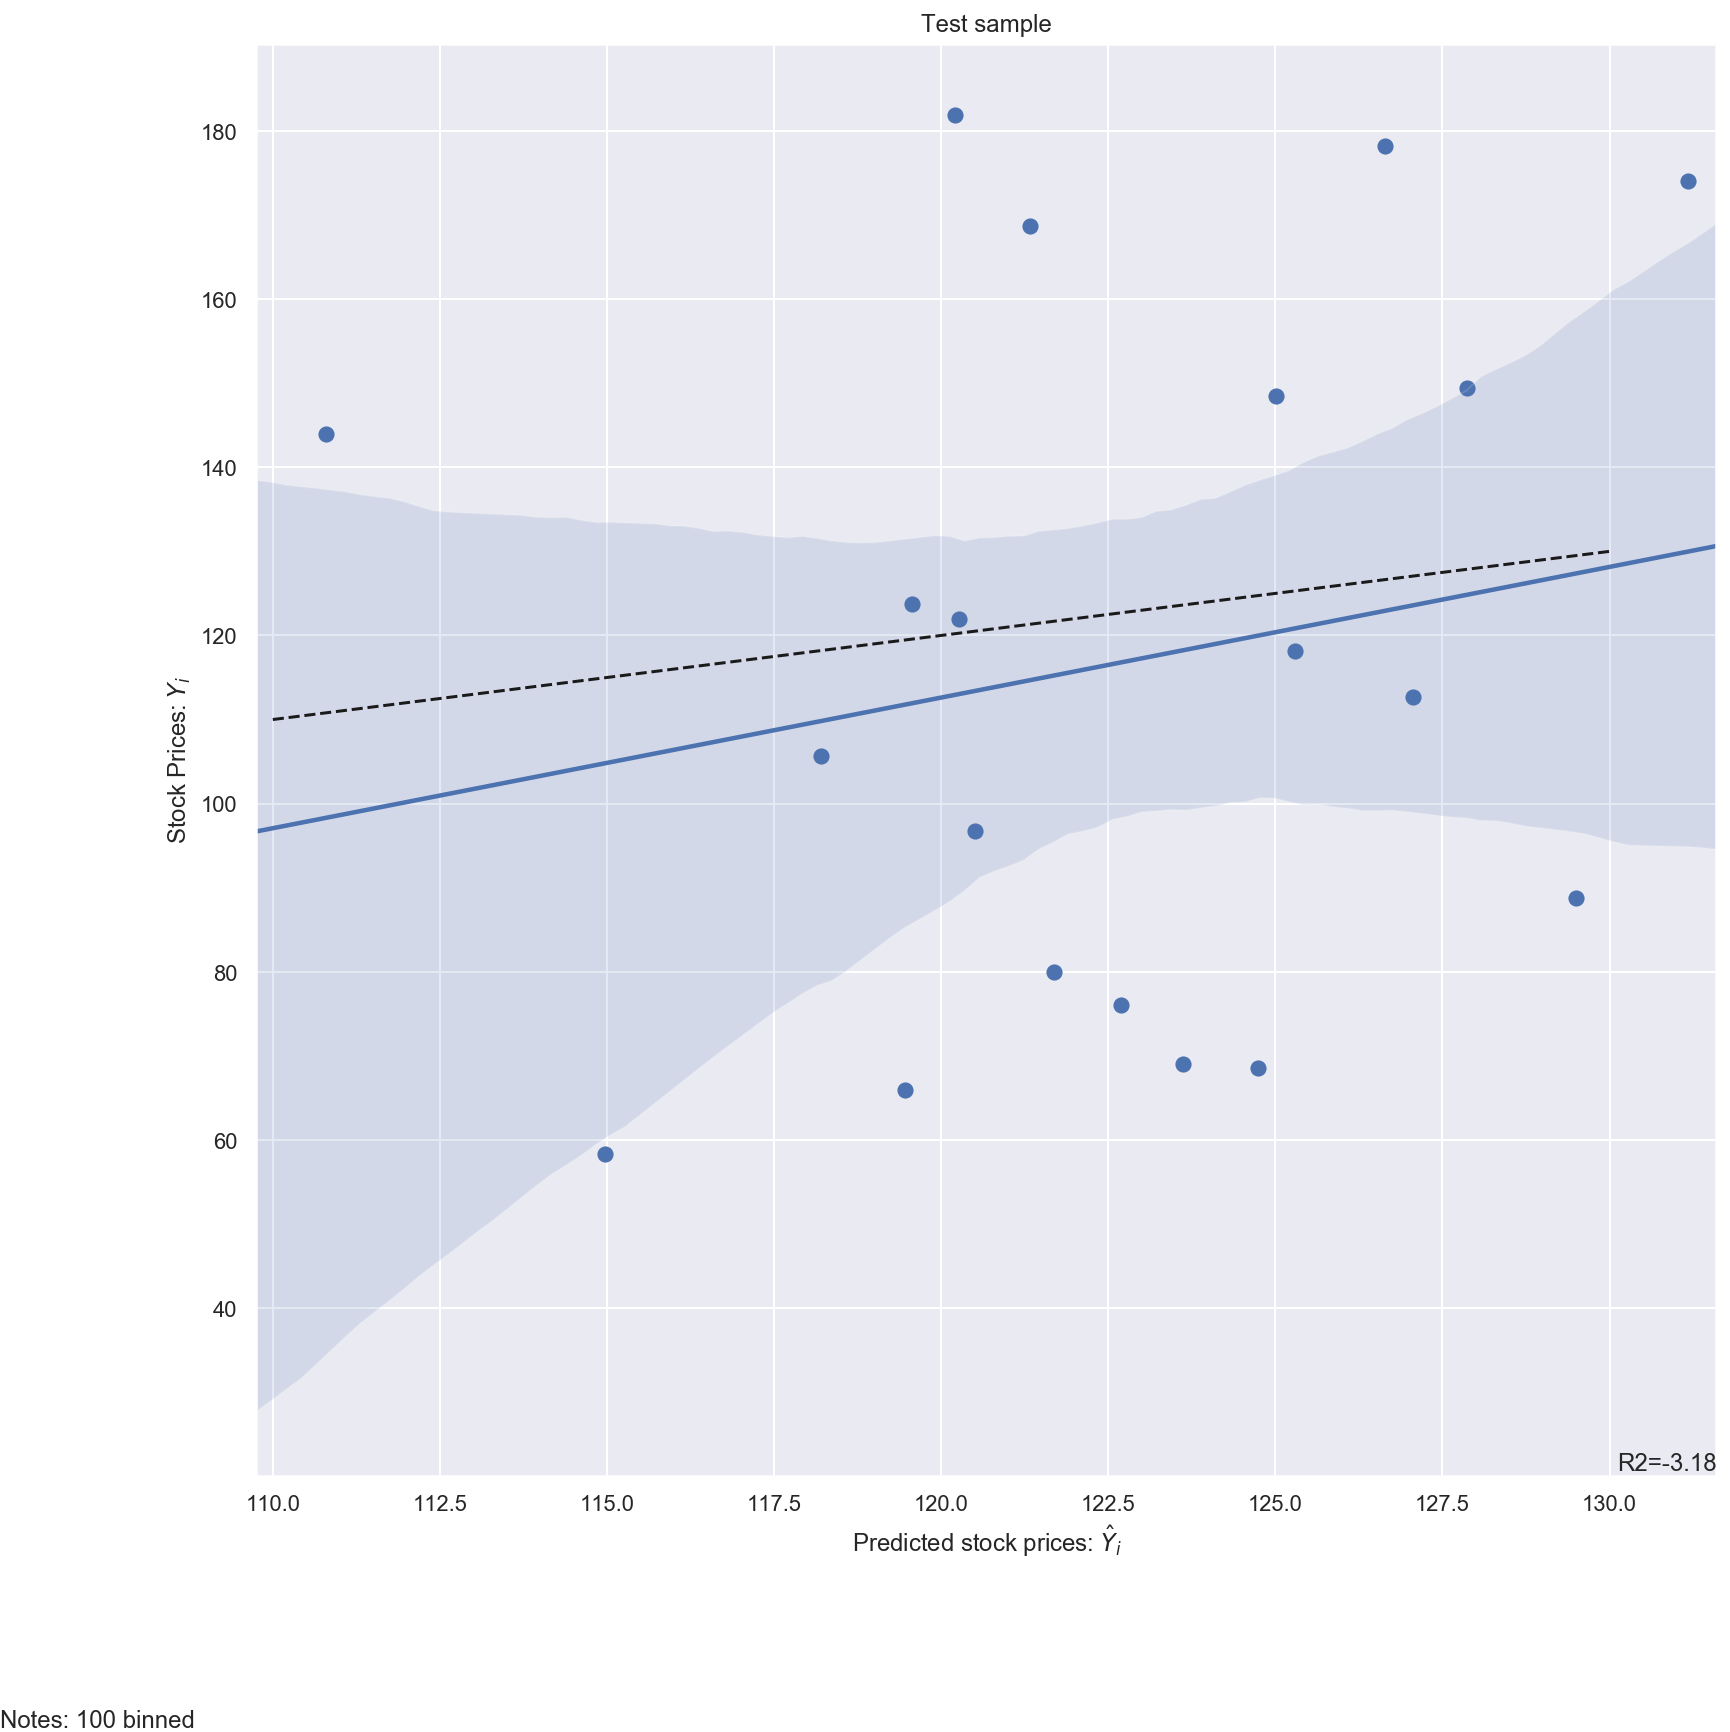

In [911]:
# temporal splitting
r2 = r2=round(r2_score(y_test2, y_test2_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([110, 130], [110, 130], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

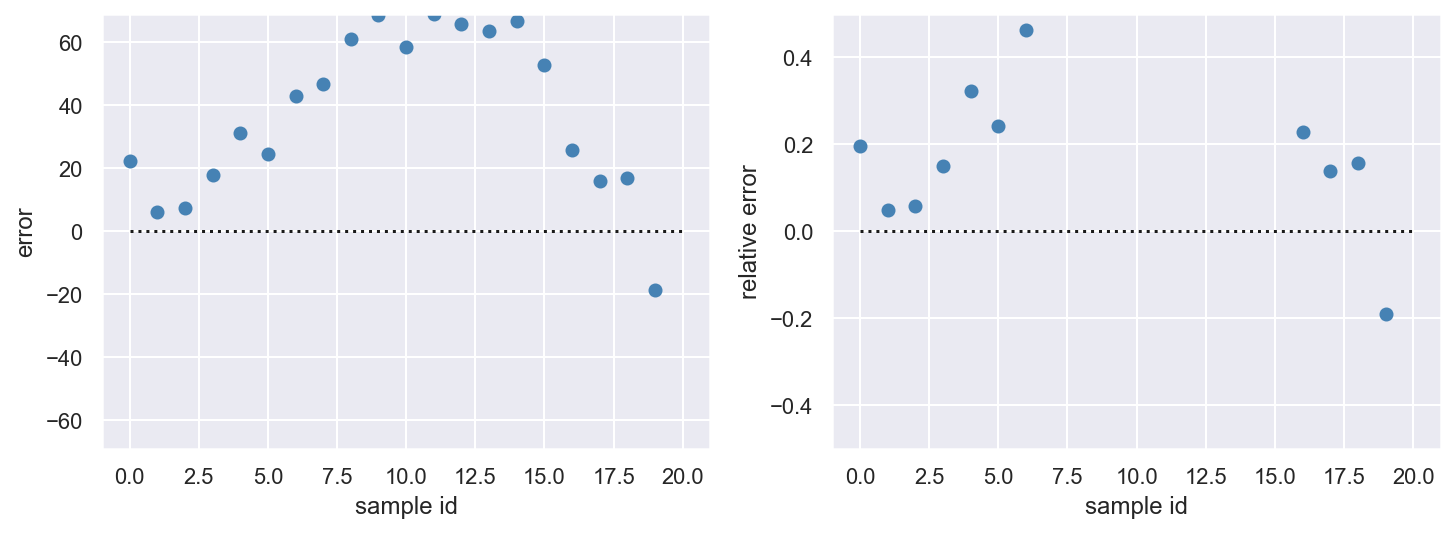

In [912]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test2, y_test2_pred)

## Lasso regression

In [913]:
lasso_reg=Lasso(alpha=1) 

### Lasso Regression - Randomized Splitting

In [914]:
# randomized splitting
lasso_reg.fit(X_train, y_train)
y_test_pred = lasso_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

test RMS: 41.00607845621664
train R2: 0.02
test R2: -0.06


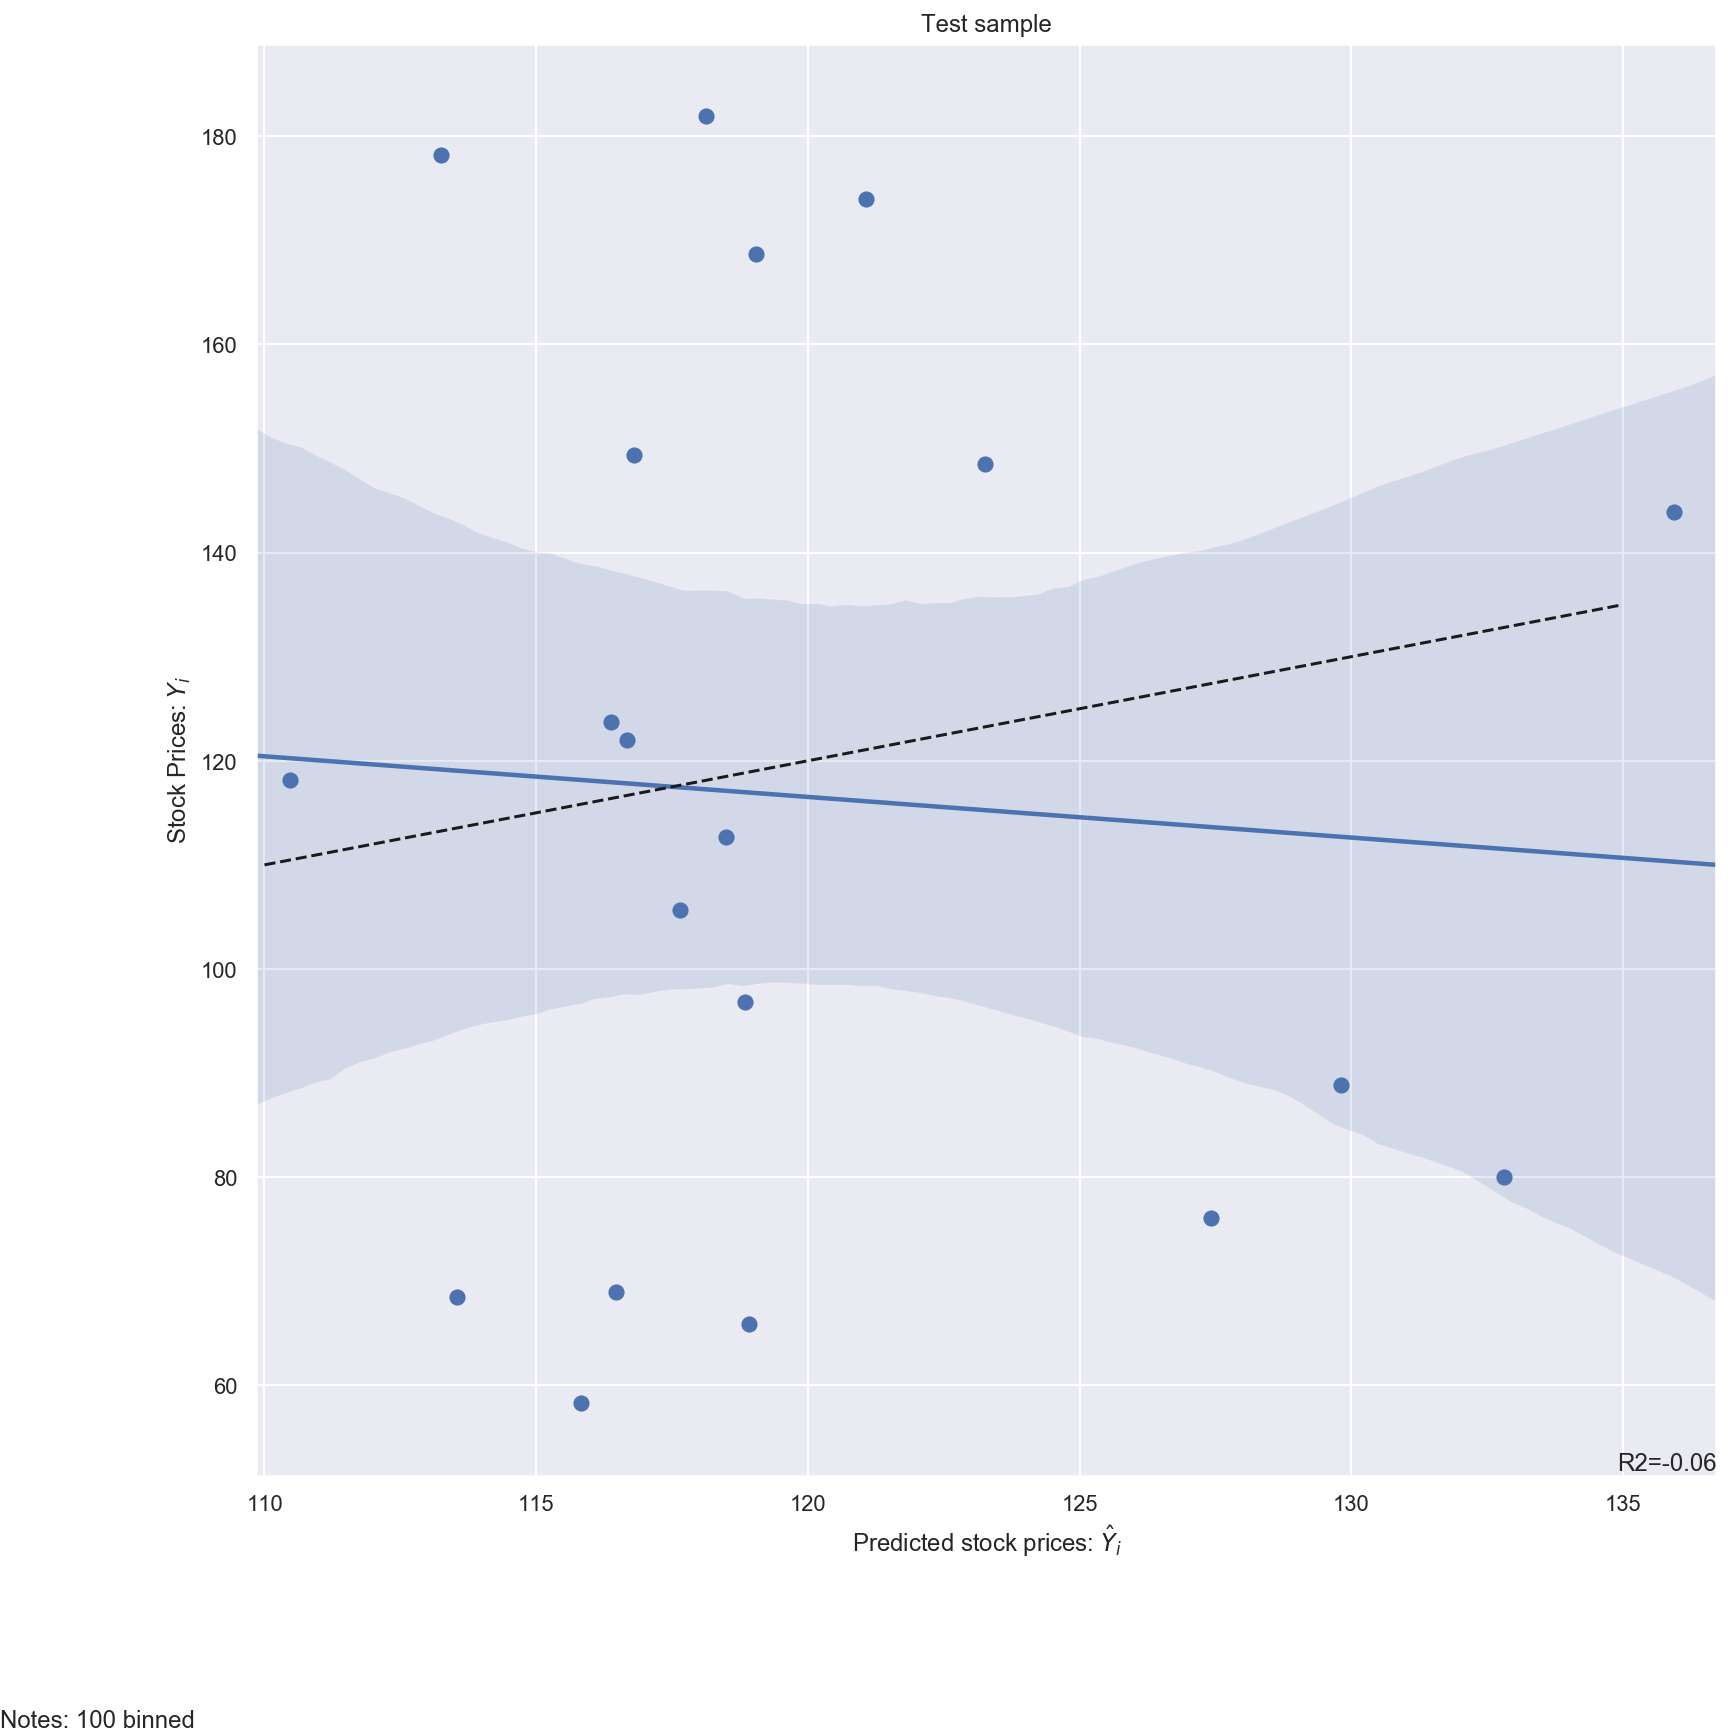

In [916]:
# randomized splitting
r2 = r2=round(r2_score(y_test, y_test_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([110, 135], [110, 135], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

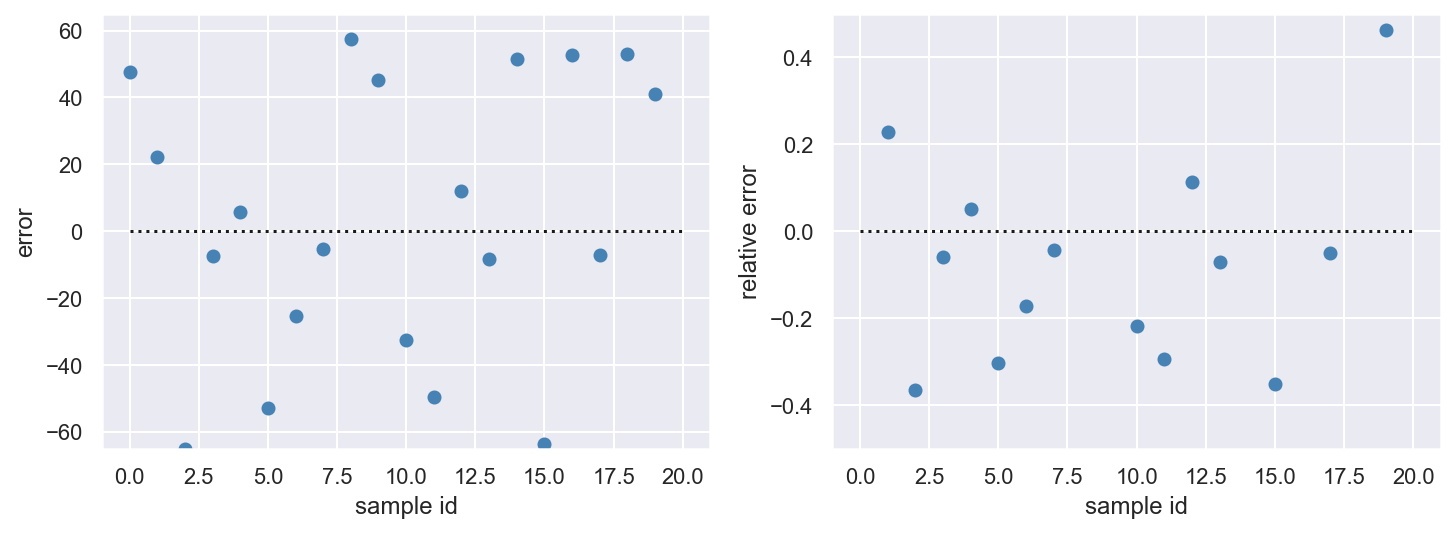

In [917]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test, y_test_pred)

### Lasso Regression - Temporal Splitting

In [918]:
# temporal splitting
lasso_reg.fit(X_train2, y_train2)
y_test_pred = lasso_reg.predict(X_test2) 
test_rmse = mean_squared_error(y_test2,y_test2_pred)
test_rmse = np.sqrt(test_rmse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train2, y_train2_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test2, y_test2_pred), 2))

test RMS: 44.83037539369807
train R2: 0.01
test R2: -3.18


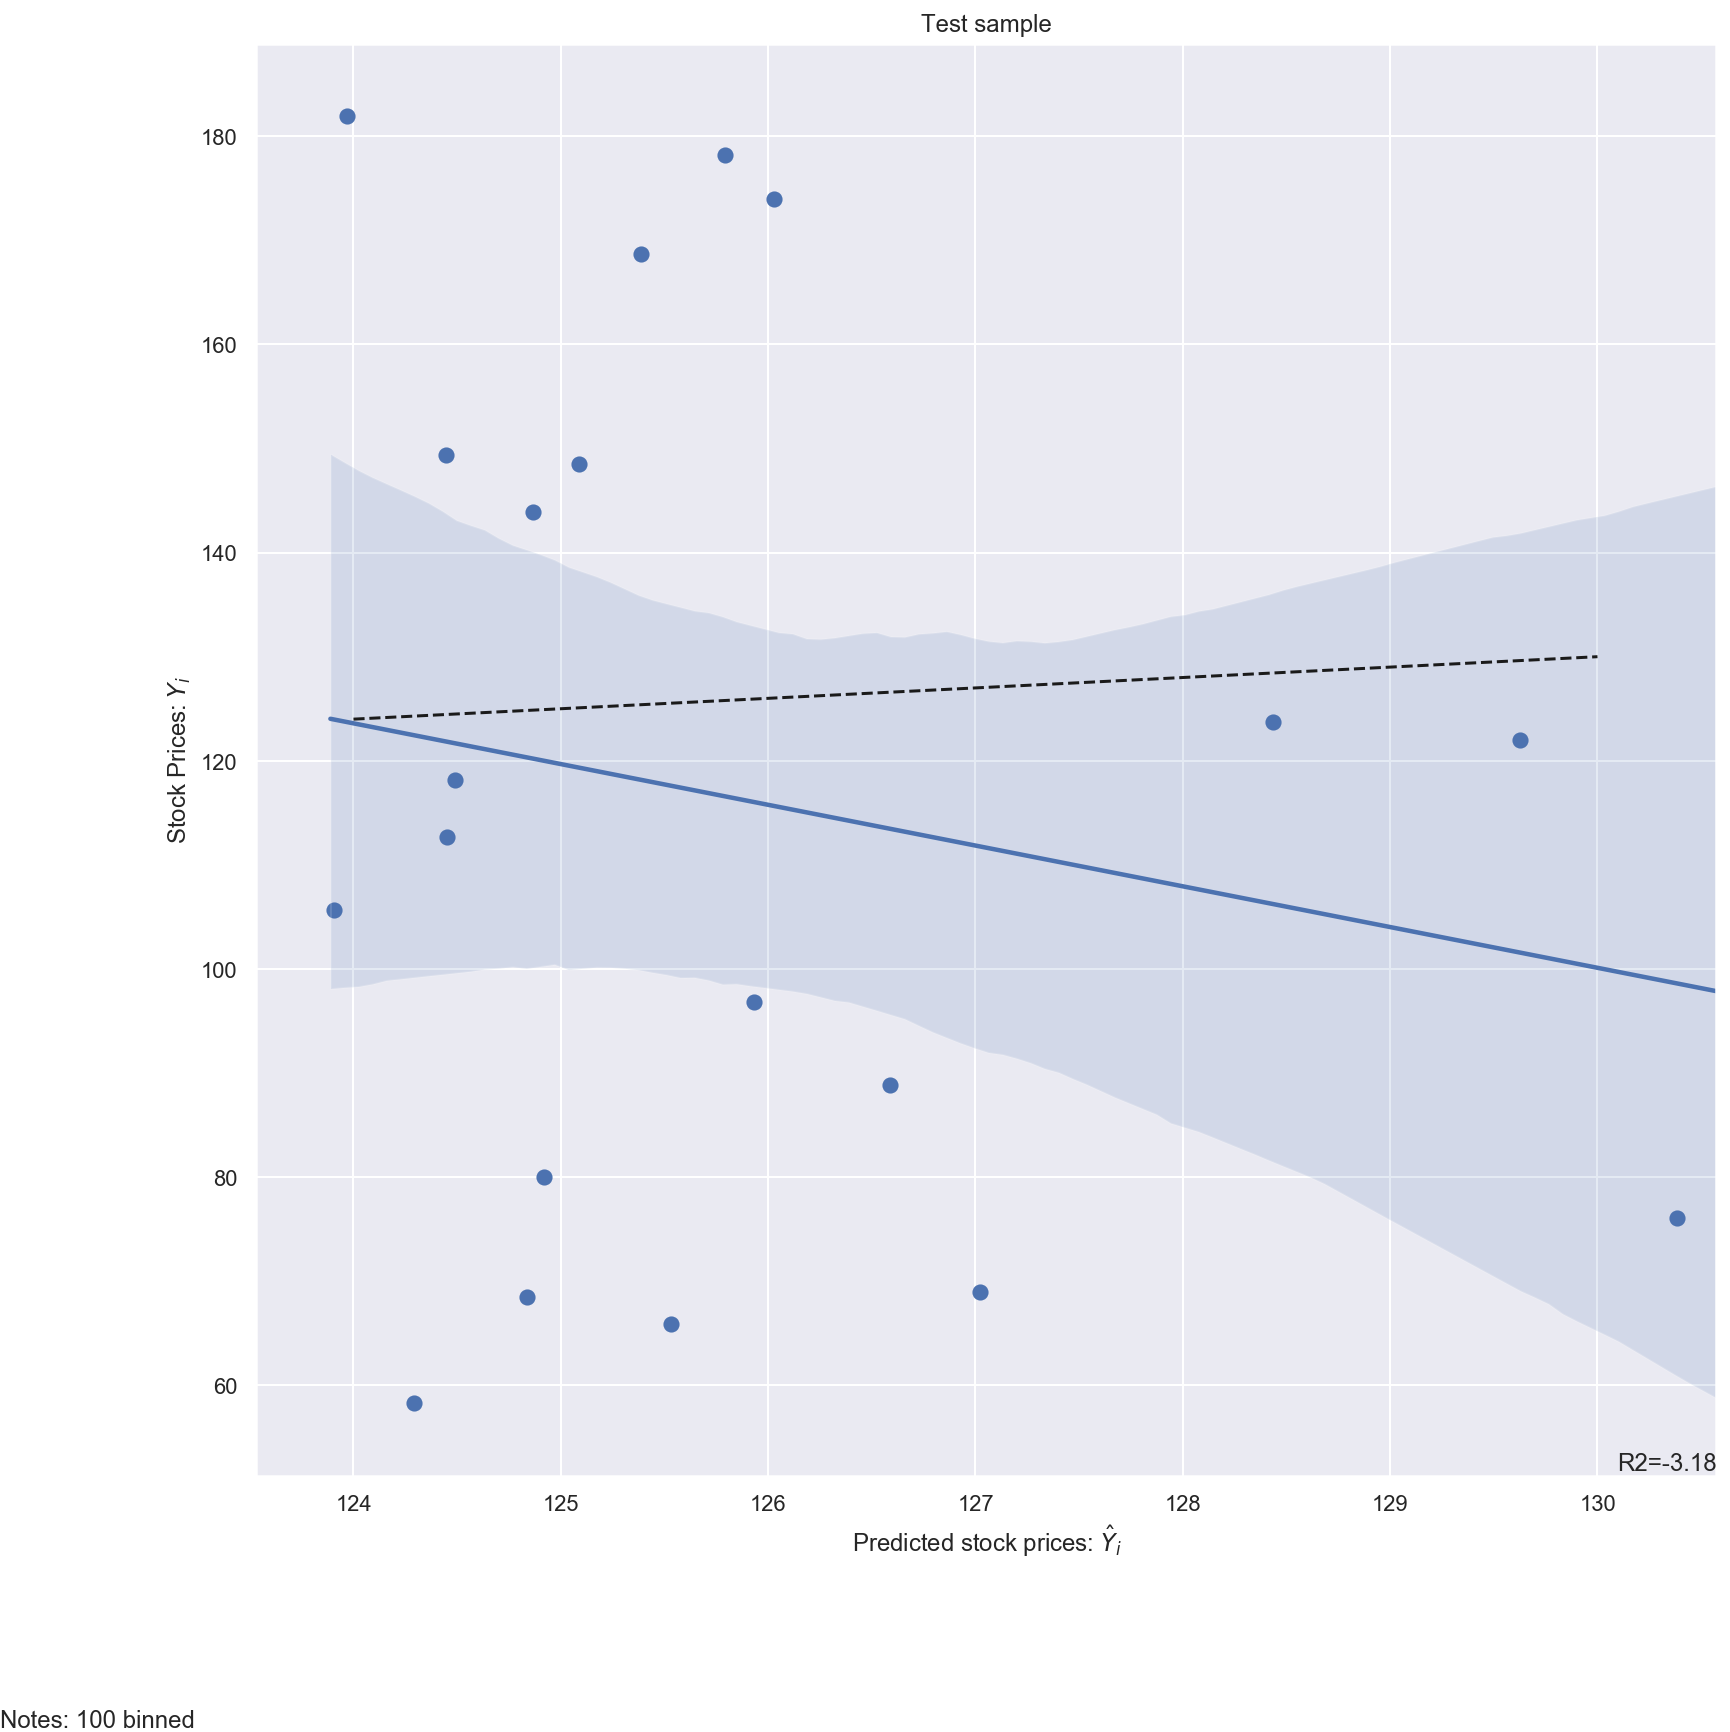

In [922]:
# temporal splitting
r2 = r2=round(r2_score(y_test2, y_test2_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([124, 130], [124, 130], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

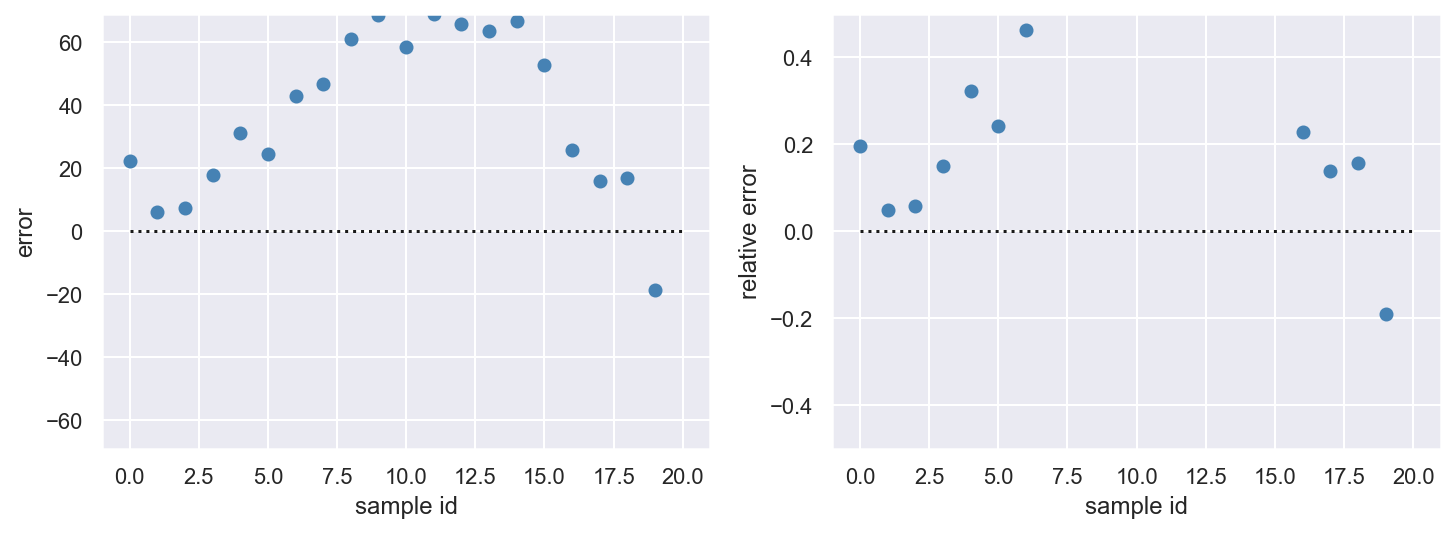

In [923]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test2, y_test2_pred)

## Elestic net

In [959]:
elanet_reg=ElasticNet(random_state=0)

### Elastic net - Randomized Splitting

In [960]:
# randomized splitting
elanet_reg.fit(X_train_scaled, y_train)

y_test_pred = elanet_reg.predict(X_test_scaled)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

test RMS: 39.80353388381898
train R2: 0.02
test R2: 0.0


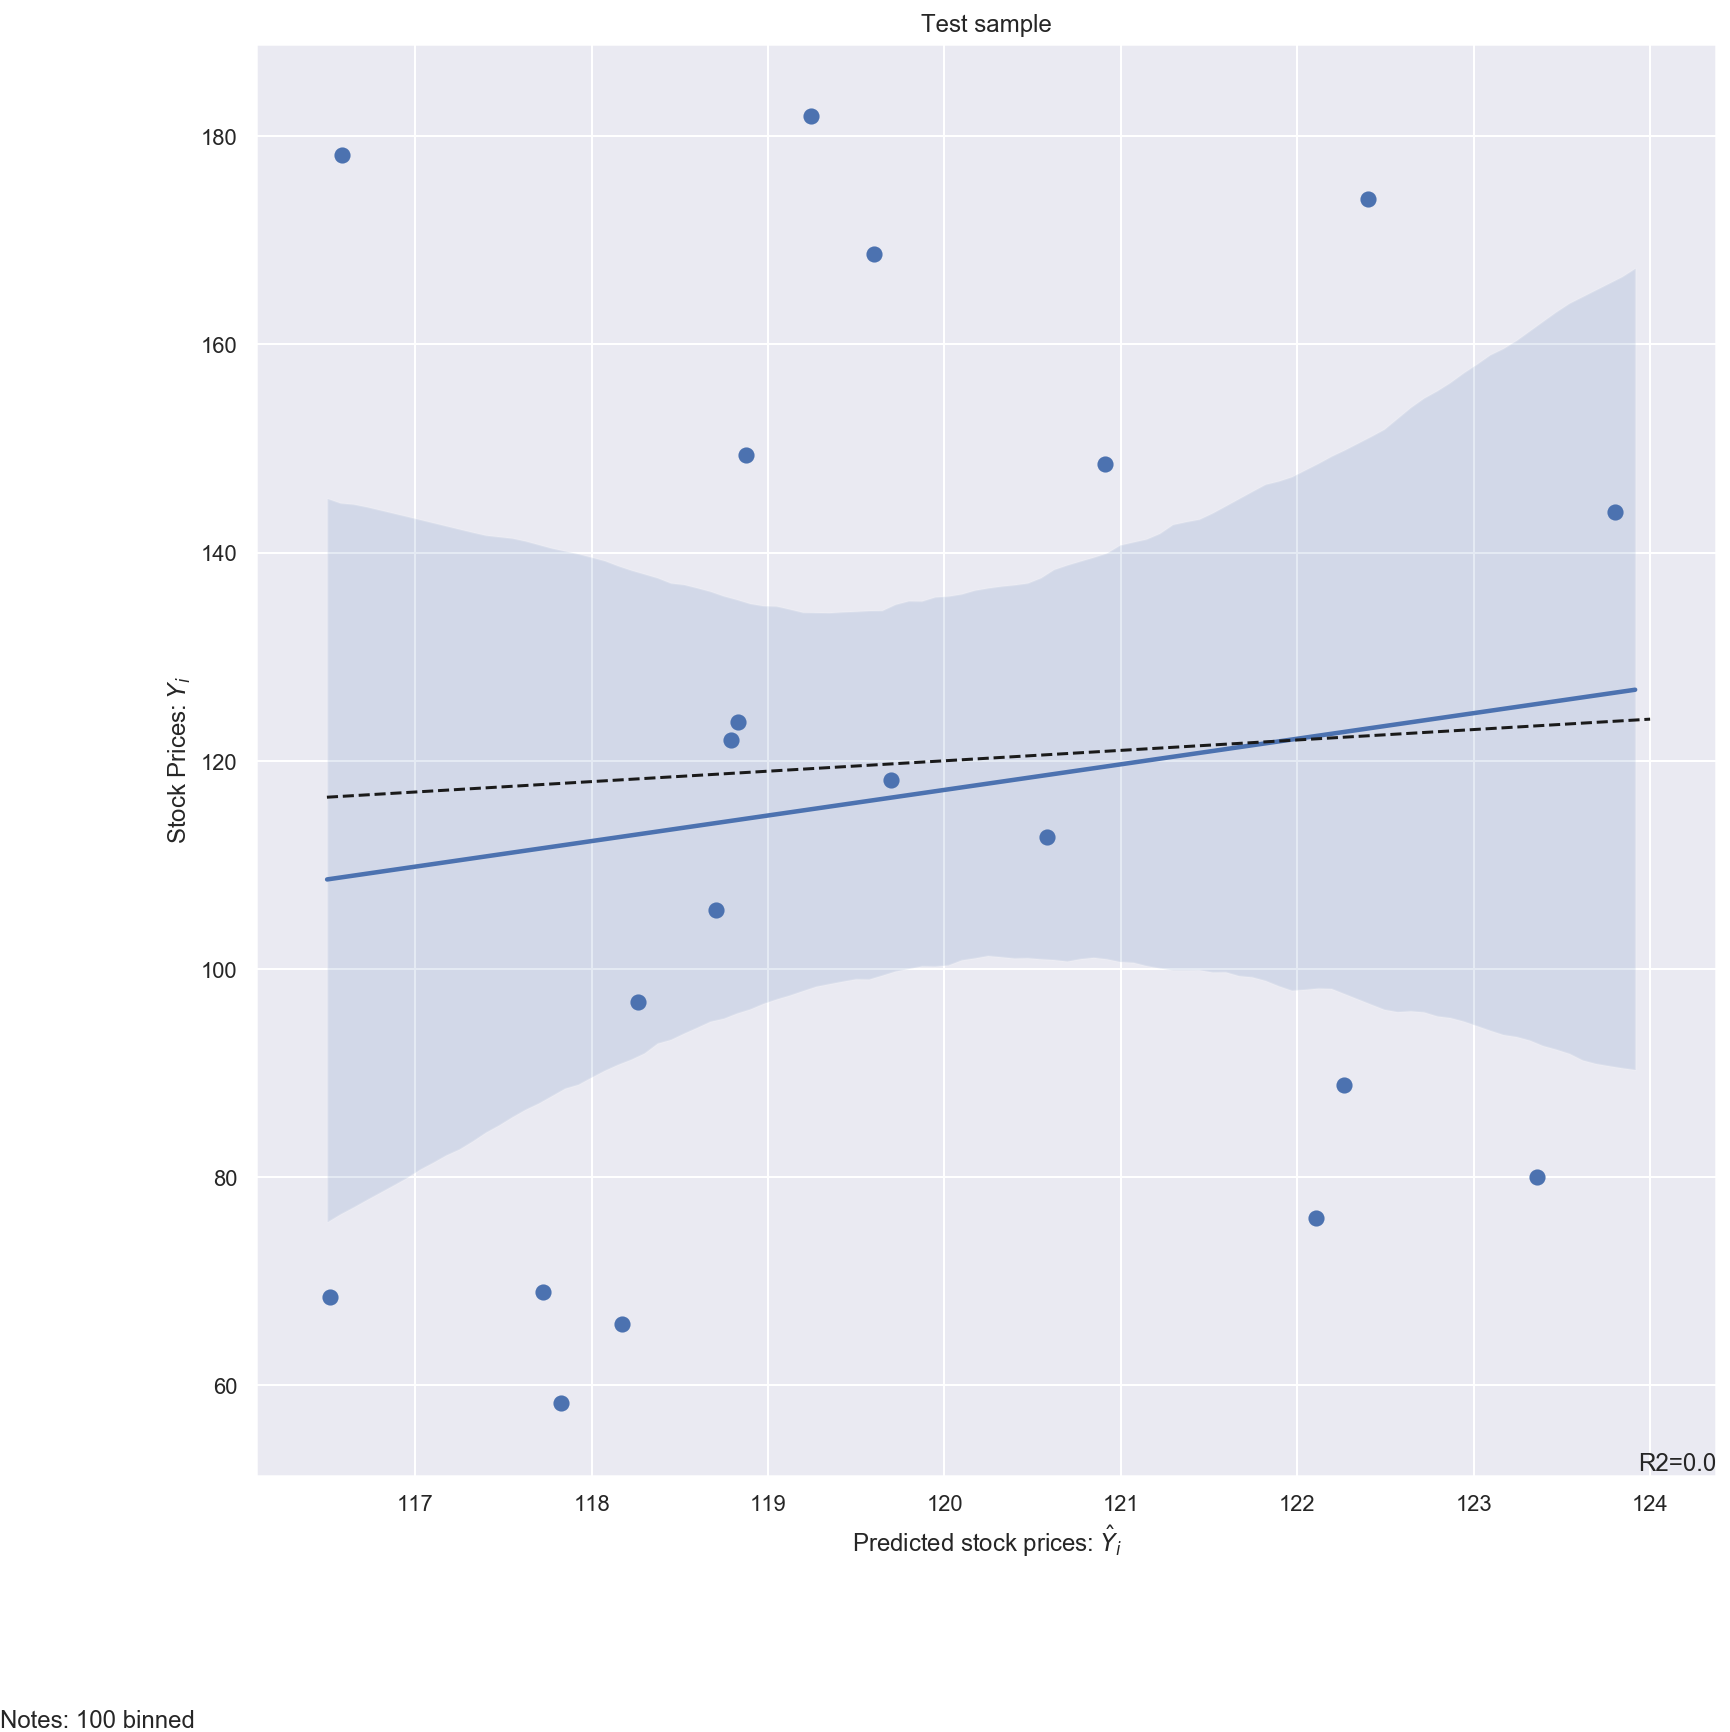

In [963]:
# randomized splitting
r2 = r2=round(r2_score(y_test, y_test_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([116.5, 124], [116.5, 124], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

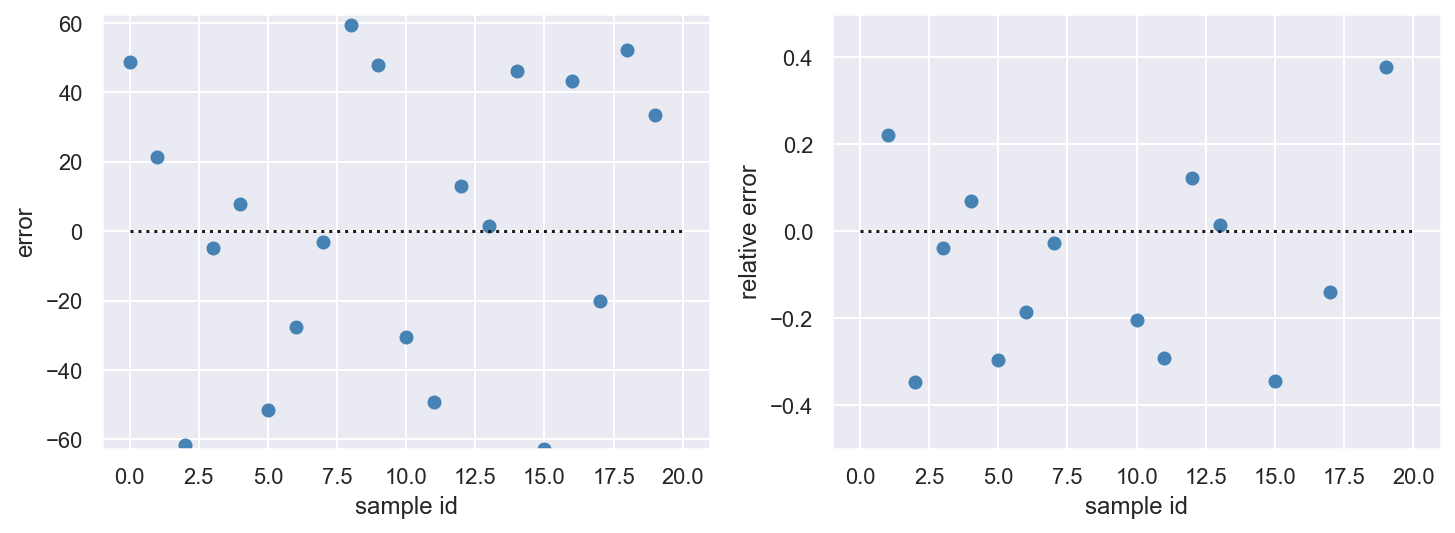

In [964]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test, y_test_pred)

### Elastic net - Temporal Splitting

In [965]:
# temporal splitting
elanet_reg.fit(X_train2_scaled, y_train2)

y_test2_pred = elanet_reg.predict(X_test2_scaled)  

test_rmse = mean_squared_error(y_test2,y_test2_pred)
test_rmse = np.sqrt(test_rmse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train2, y_train2_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test2, y_test2_pred), 2))

test RMS: 40.69827949678551
train R2: -1.75
test R2: -2.45


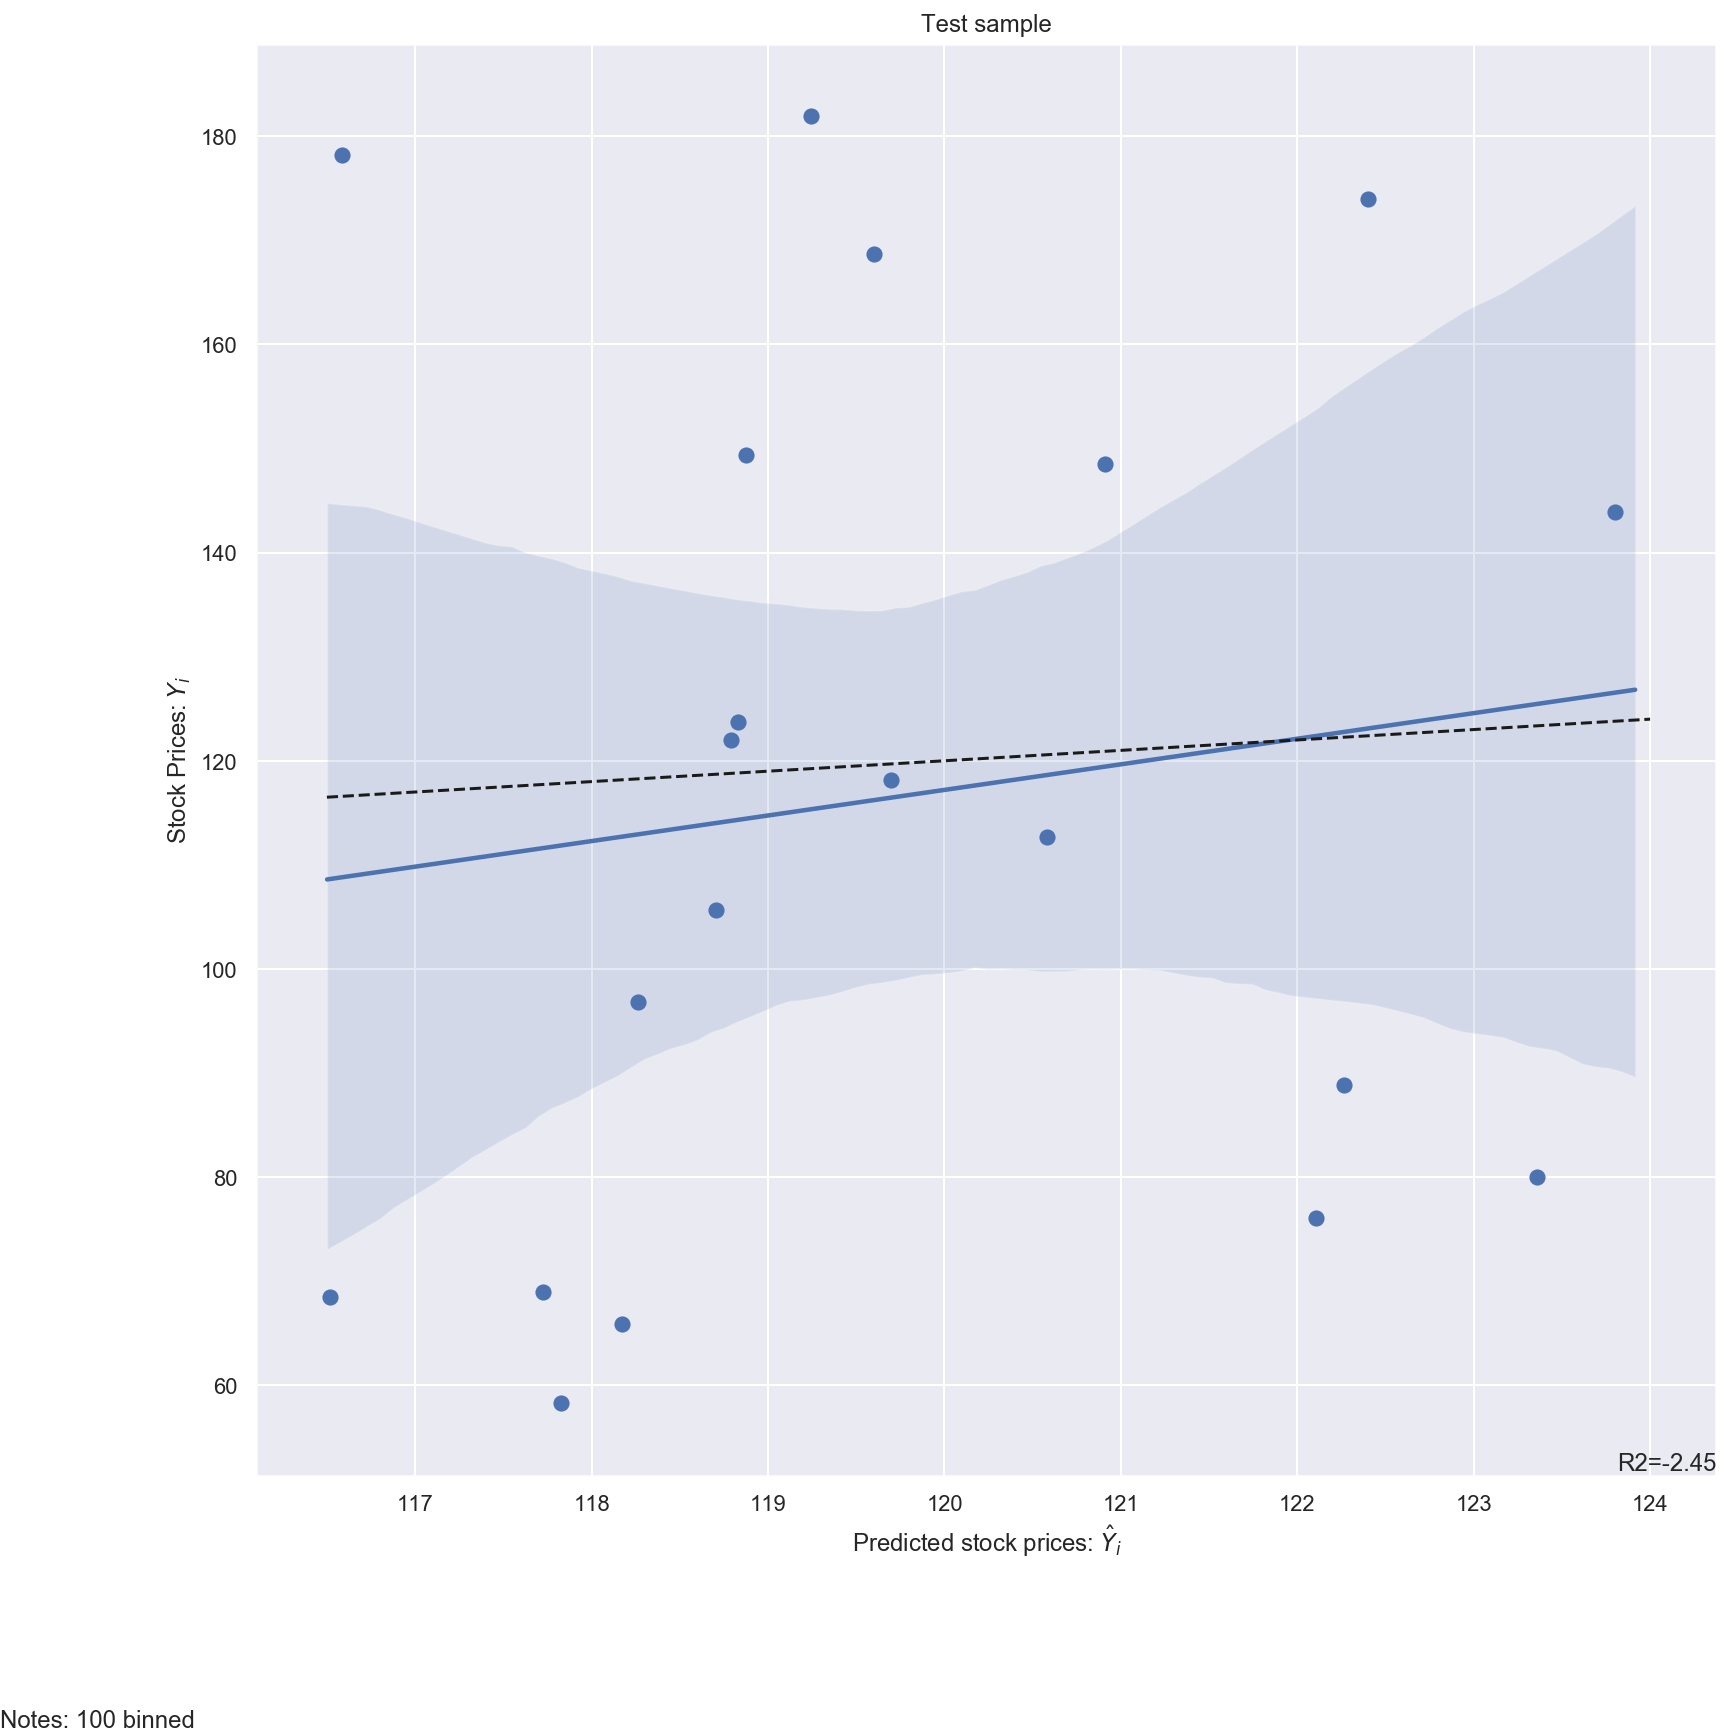

In [967]:
# temporal splitting
r2 = r2=round(r2_score(y_test2, y_test2_pred), 2)

# Regplot (code taken from the lecture Notebook W3)
g=sns.regplot(x= y_test_pred, y=y_test, x_bins = 100)
g=g.set_title("Test sample")
plt.xlabel("Predicted stock prices: $\hat{Y}_i$")
plt.ylabel("Stock Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([116.5, 124], [116.5, 124], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

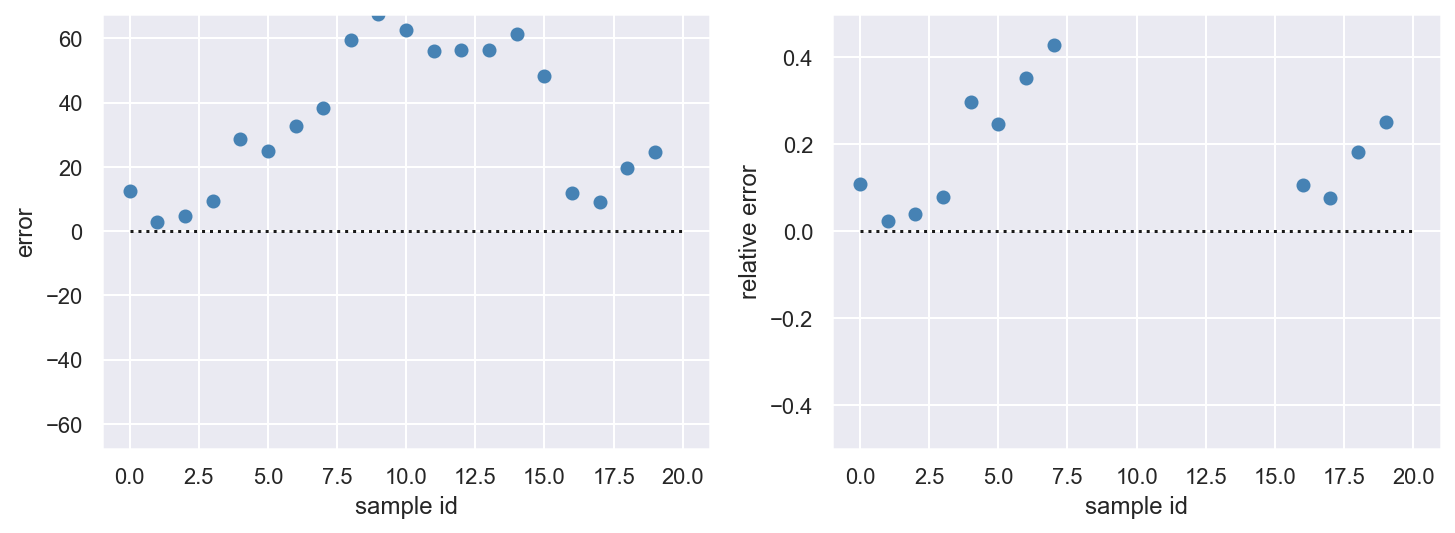

In [968]:
#Let us plot how good given and predicted values match on the training data set (code taken from the lecture Notebook W3)
plot_fit_quality(y_test2, y_test2_pred)

**Step 3: text analysis** [week 4]
- Featurize tweets (or another text dataset related to your subject): transform the text into a standard document-level dataset `X_doc`

**Step 2b: estimate different regression models using `X_doc` and `y`** [week 3]

**Step 4: estimate a classification models** [week 5]
- propose a categorical variable `y_calc` that you can compute from the continuous one (`y`) (e.g. positive or negative growthin stock prices). For the `X` dimension, you can use `X_doc` or `X_num` or both. 
- you can use any other categorical variable that you find relevant

**Step 6: Dimension reduction** [week 6]
- Use one of the dimension reductions methods to dimension-reduce the features
    - PCA or topic model (LDA or STM) or k-means clustering on the featurized text `X_doc`
- Run another classifier


**Step bonus: Econometric identification** [week 8]
- Find an exogenous shock affecting this firm (but not all the firms) and a control group of firms not affected
    - example: a natural disaster/shock to the exchange rate/change in ownership... affects the functionning of this firm but not the other firms of the stock market index.  
- scale up the previous data collection to the firms in the control group
- use one of the technique studied in class to causaly identify the impact of the exogenous shock on the stock market of the affected firm